1. Weights distribution for query, key, values
2. Weights distribution for other layers
3. Attention score vs token per attention head
4. Attention score vs token per layer

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
config = AutoConfig.from_pretrained("bert-base-uncased",output_hidden_states=True,output_attentions=True)
model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
COLORMAP=['red','green','blue','red','violet','pink','orange','black','cyan','sandybrown','red','salmon']
#sns.set(rc={'figure.figsize':(60,20)})
sns.set(font_scale=3)
#plt.rcParams.update({'font.size': 5})

In [63]:
#graph.py
def plot_hist(data, **kwargs):
  sns.histplot(data, **kwargs)

def plot_kde(data, **kwargs):
  sns.kdeplot(data, **kwargs)

def plot_barplot(x, **kwargs):
  sns.barplot(x=x, **kwargs)

def layer_wise_summary(**kwargs):
  layer_wise_weights = kwargs["layer_wise_weights"]
  row_num, col_num = kwargs["row_num"], kwargs["col_num"]
  layer_keys = kwargs["layer_keys"]
  method = kwargs["method"]
  method_kwargs = kwargs.get("method_kwargs",{})

  row = 0
  col = 0
  fig, ax = plt.subplots(row_num,col_num,figsize=(45,45))
  for each_layer_key in layer_keys:
    method_kwargs["ax"]=ax[row][col]
    method_kwargs["color"]=COLORMAP[row]
    method(layer_wise_weights[each_layer_key].flatten().detach().numpy(), **method_kwargs)
    ax[row][col].set_title(each_layer_key)
    col = (col+1)%col_num
    if col == 0:
      row = row+1

  fig.tight_layout()
  plt.show()


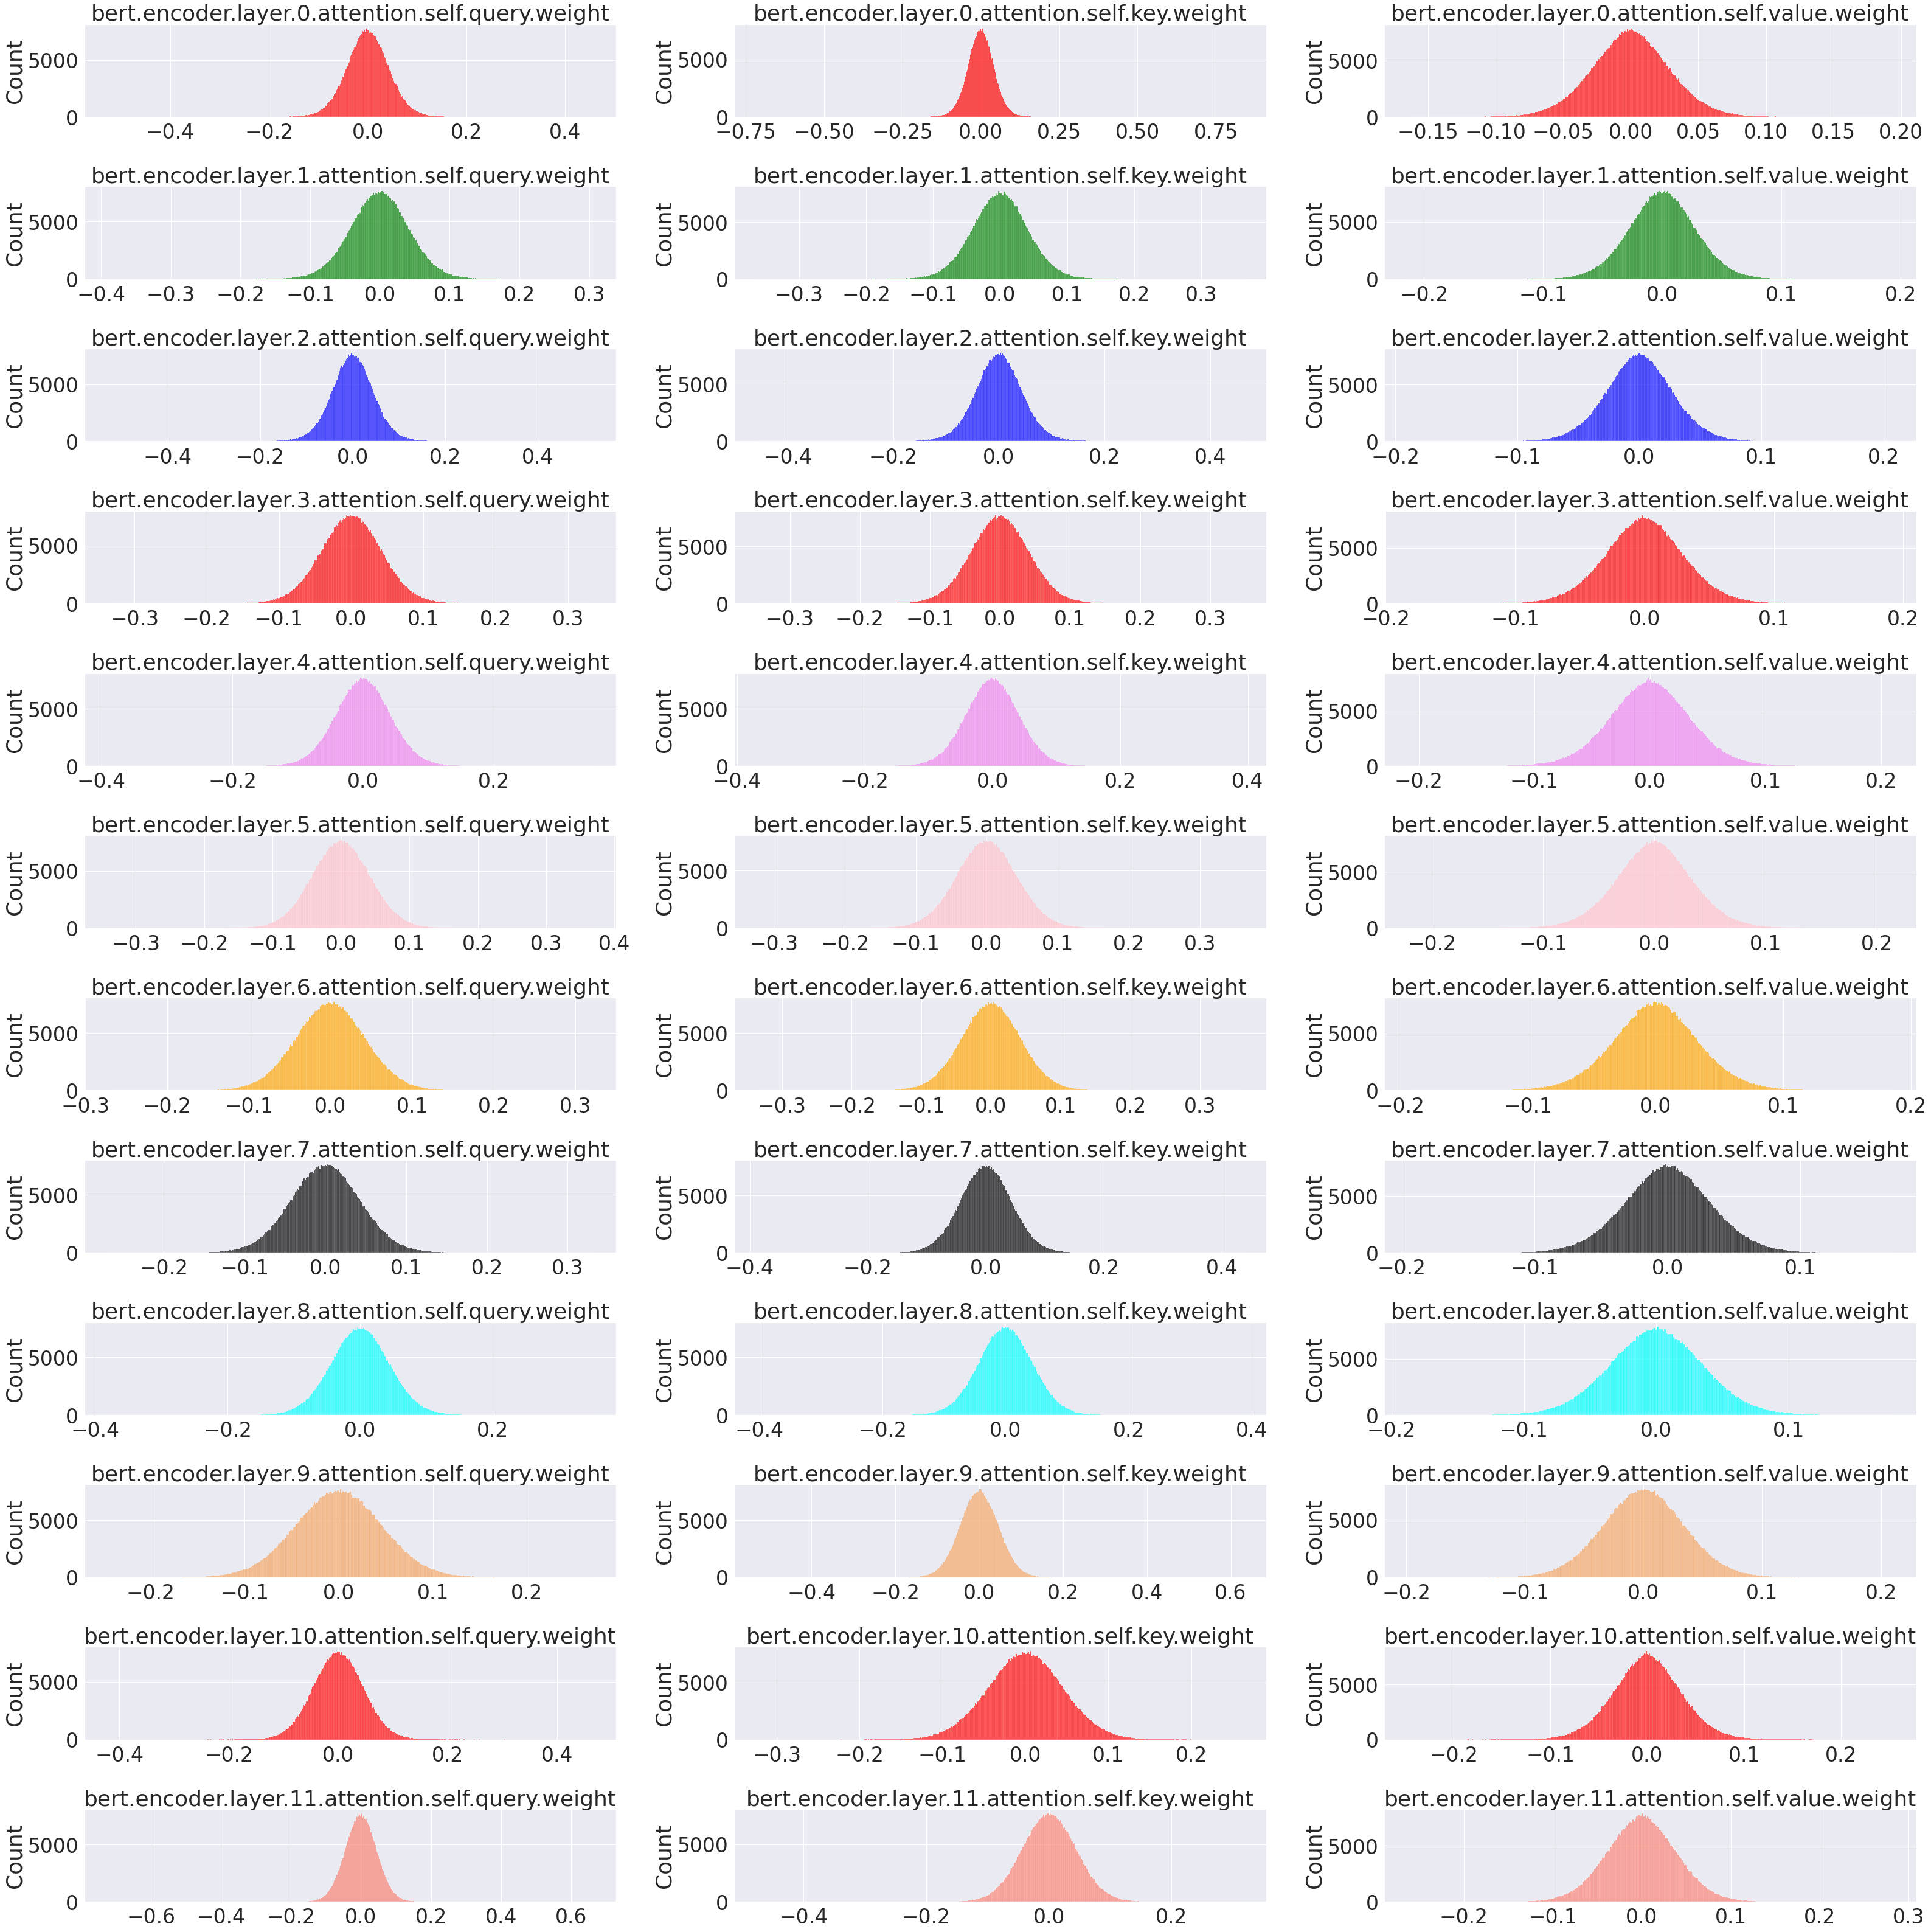

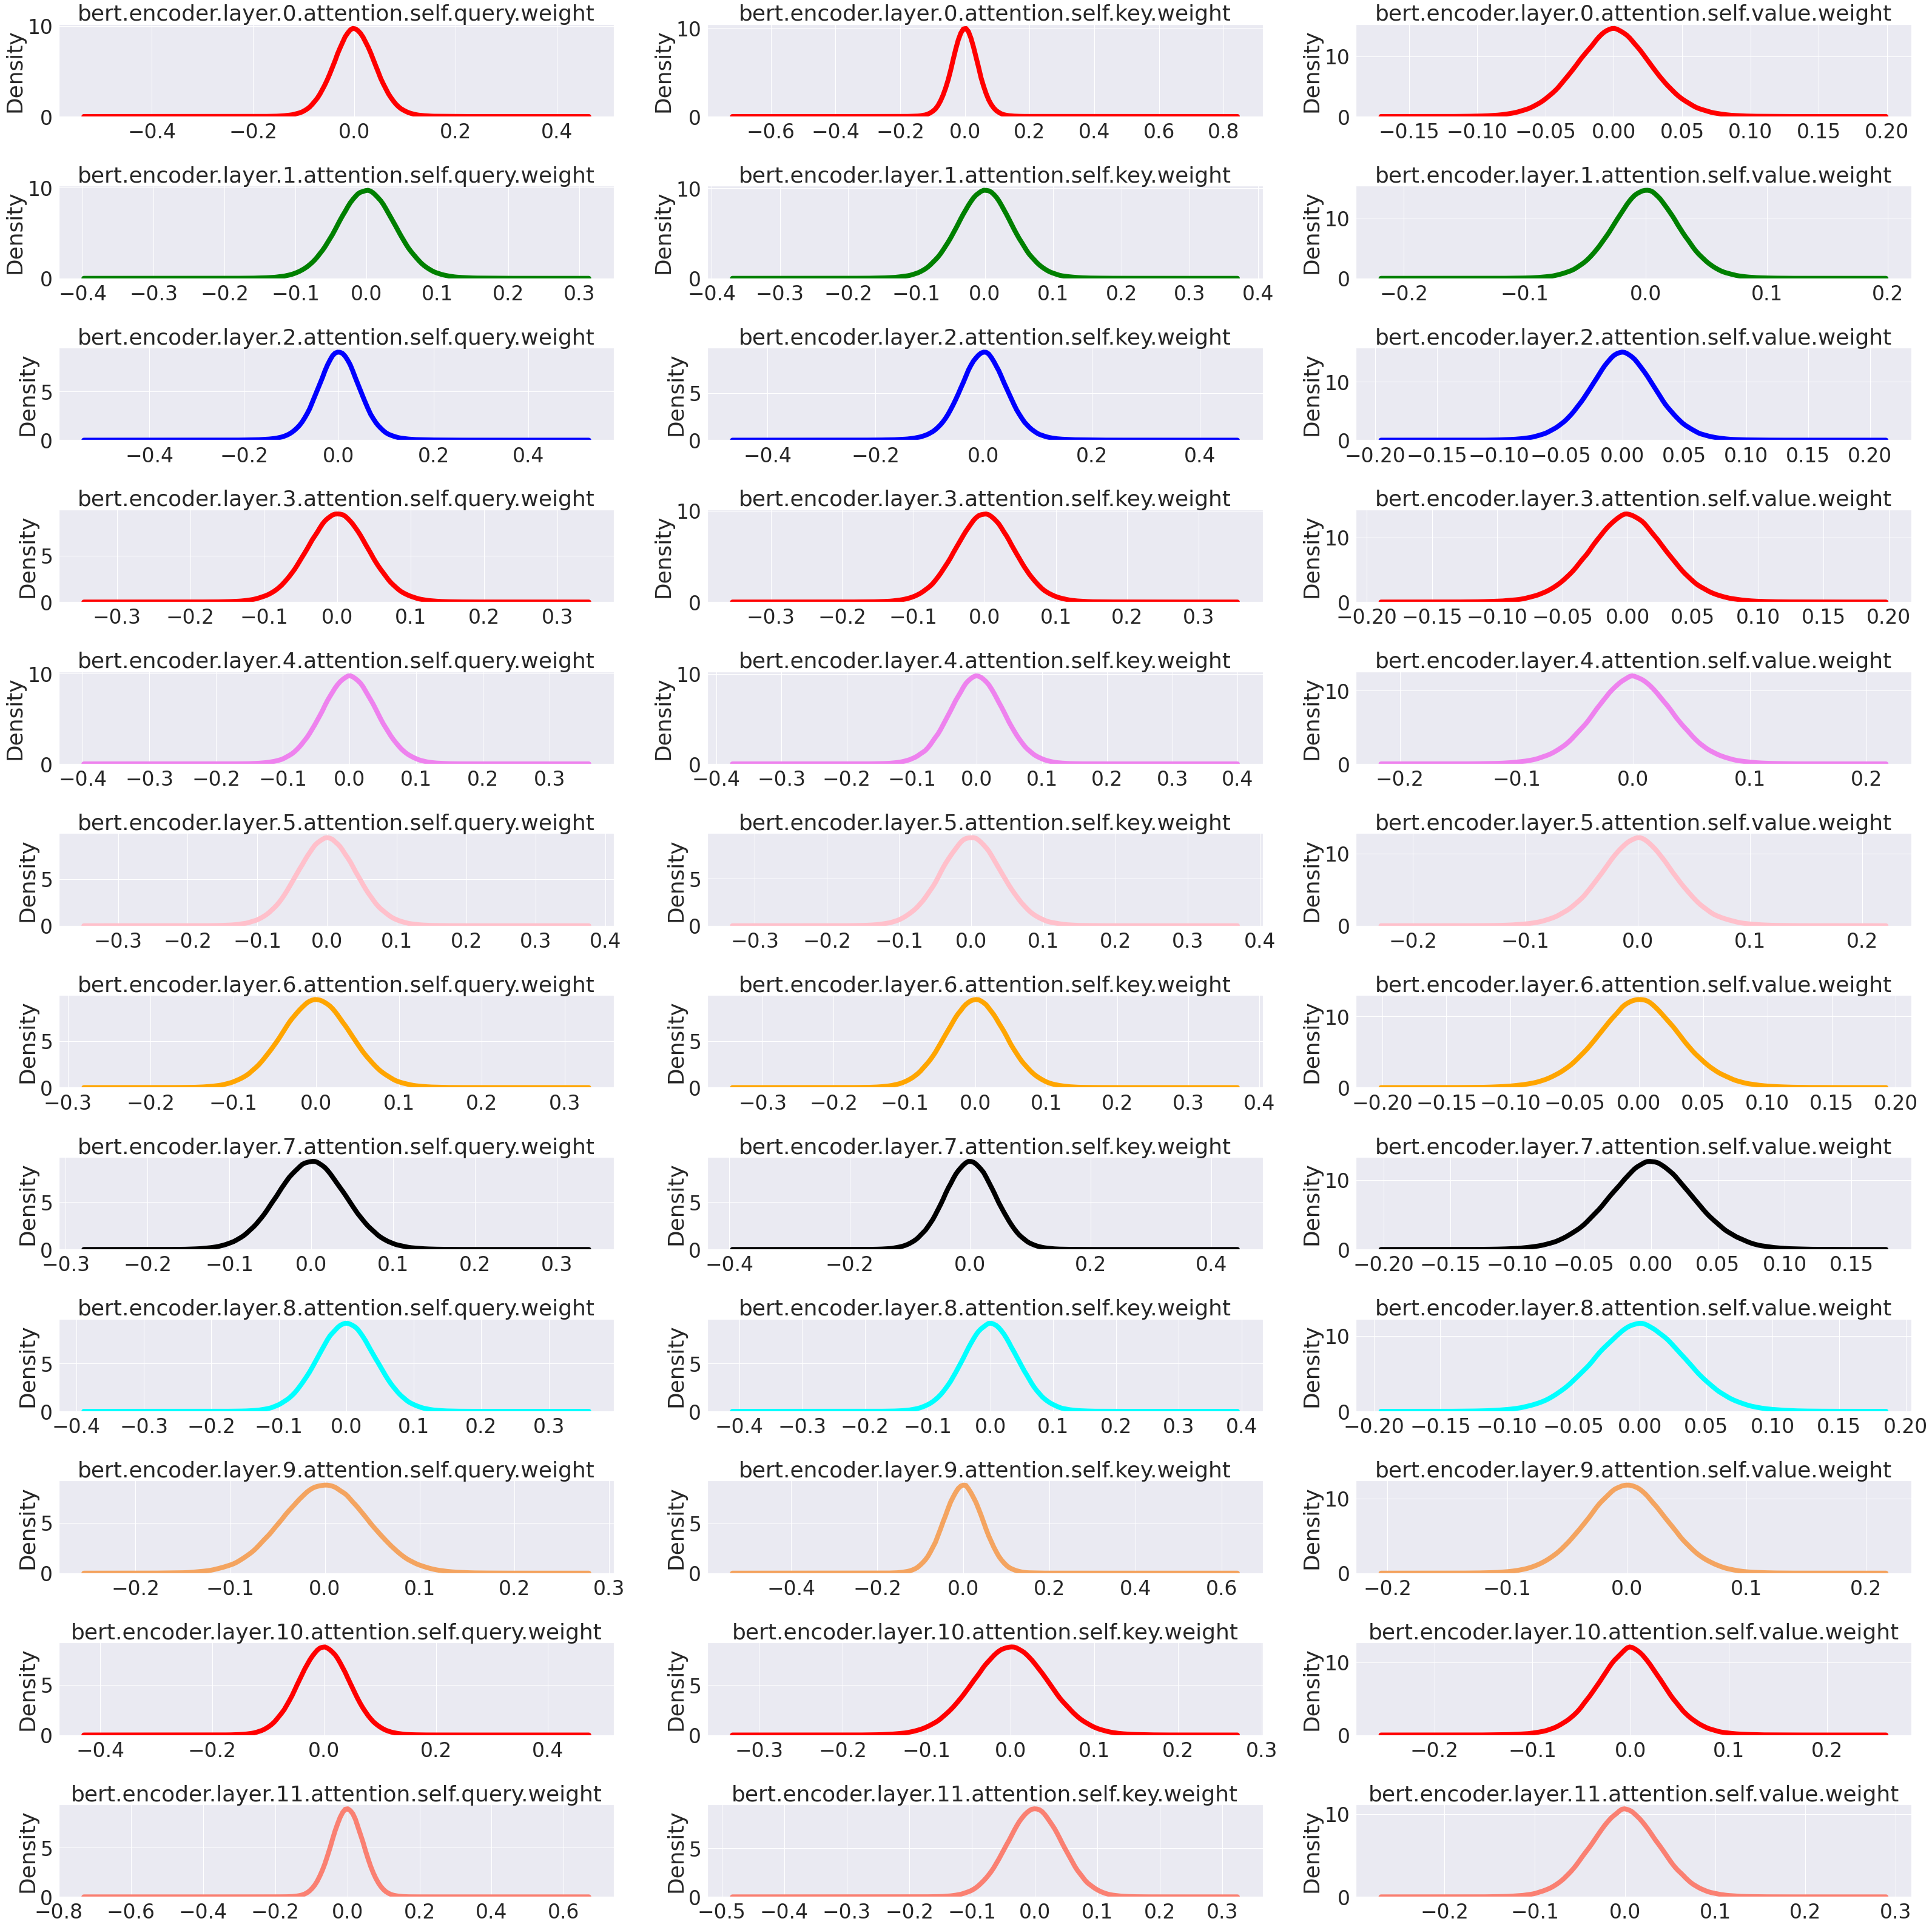

In [ ]:
layer_wise_weights = model.state_dict()
layer_keys = [ y for i in range(0, 12)  for y in ['bert.encoder.layer.{}.attention.self.query.weight'.format(i),\
              'bert.encoder.layer.{}.attention.self.key.weight'.format(i),\
              'bert.encoder.layer.{}.attention.self.value.weight'.format(i)]]
h_args = {
    "layer_wise_weights":layer_wise_weights,
    "row_num":12,"col_num":3,"layer_keys":layer_keys,"method":plot_hist,
}
layer_wise_summary(**h_args)
h_args["method"] = plot_kde
h_args["method_kwargs"] = {"linewidth":8.0}
layer_wise_summary(**h_args)

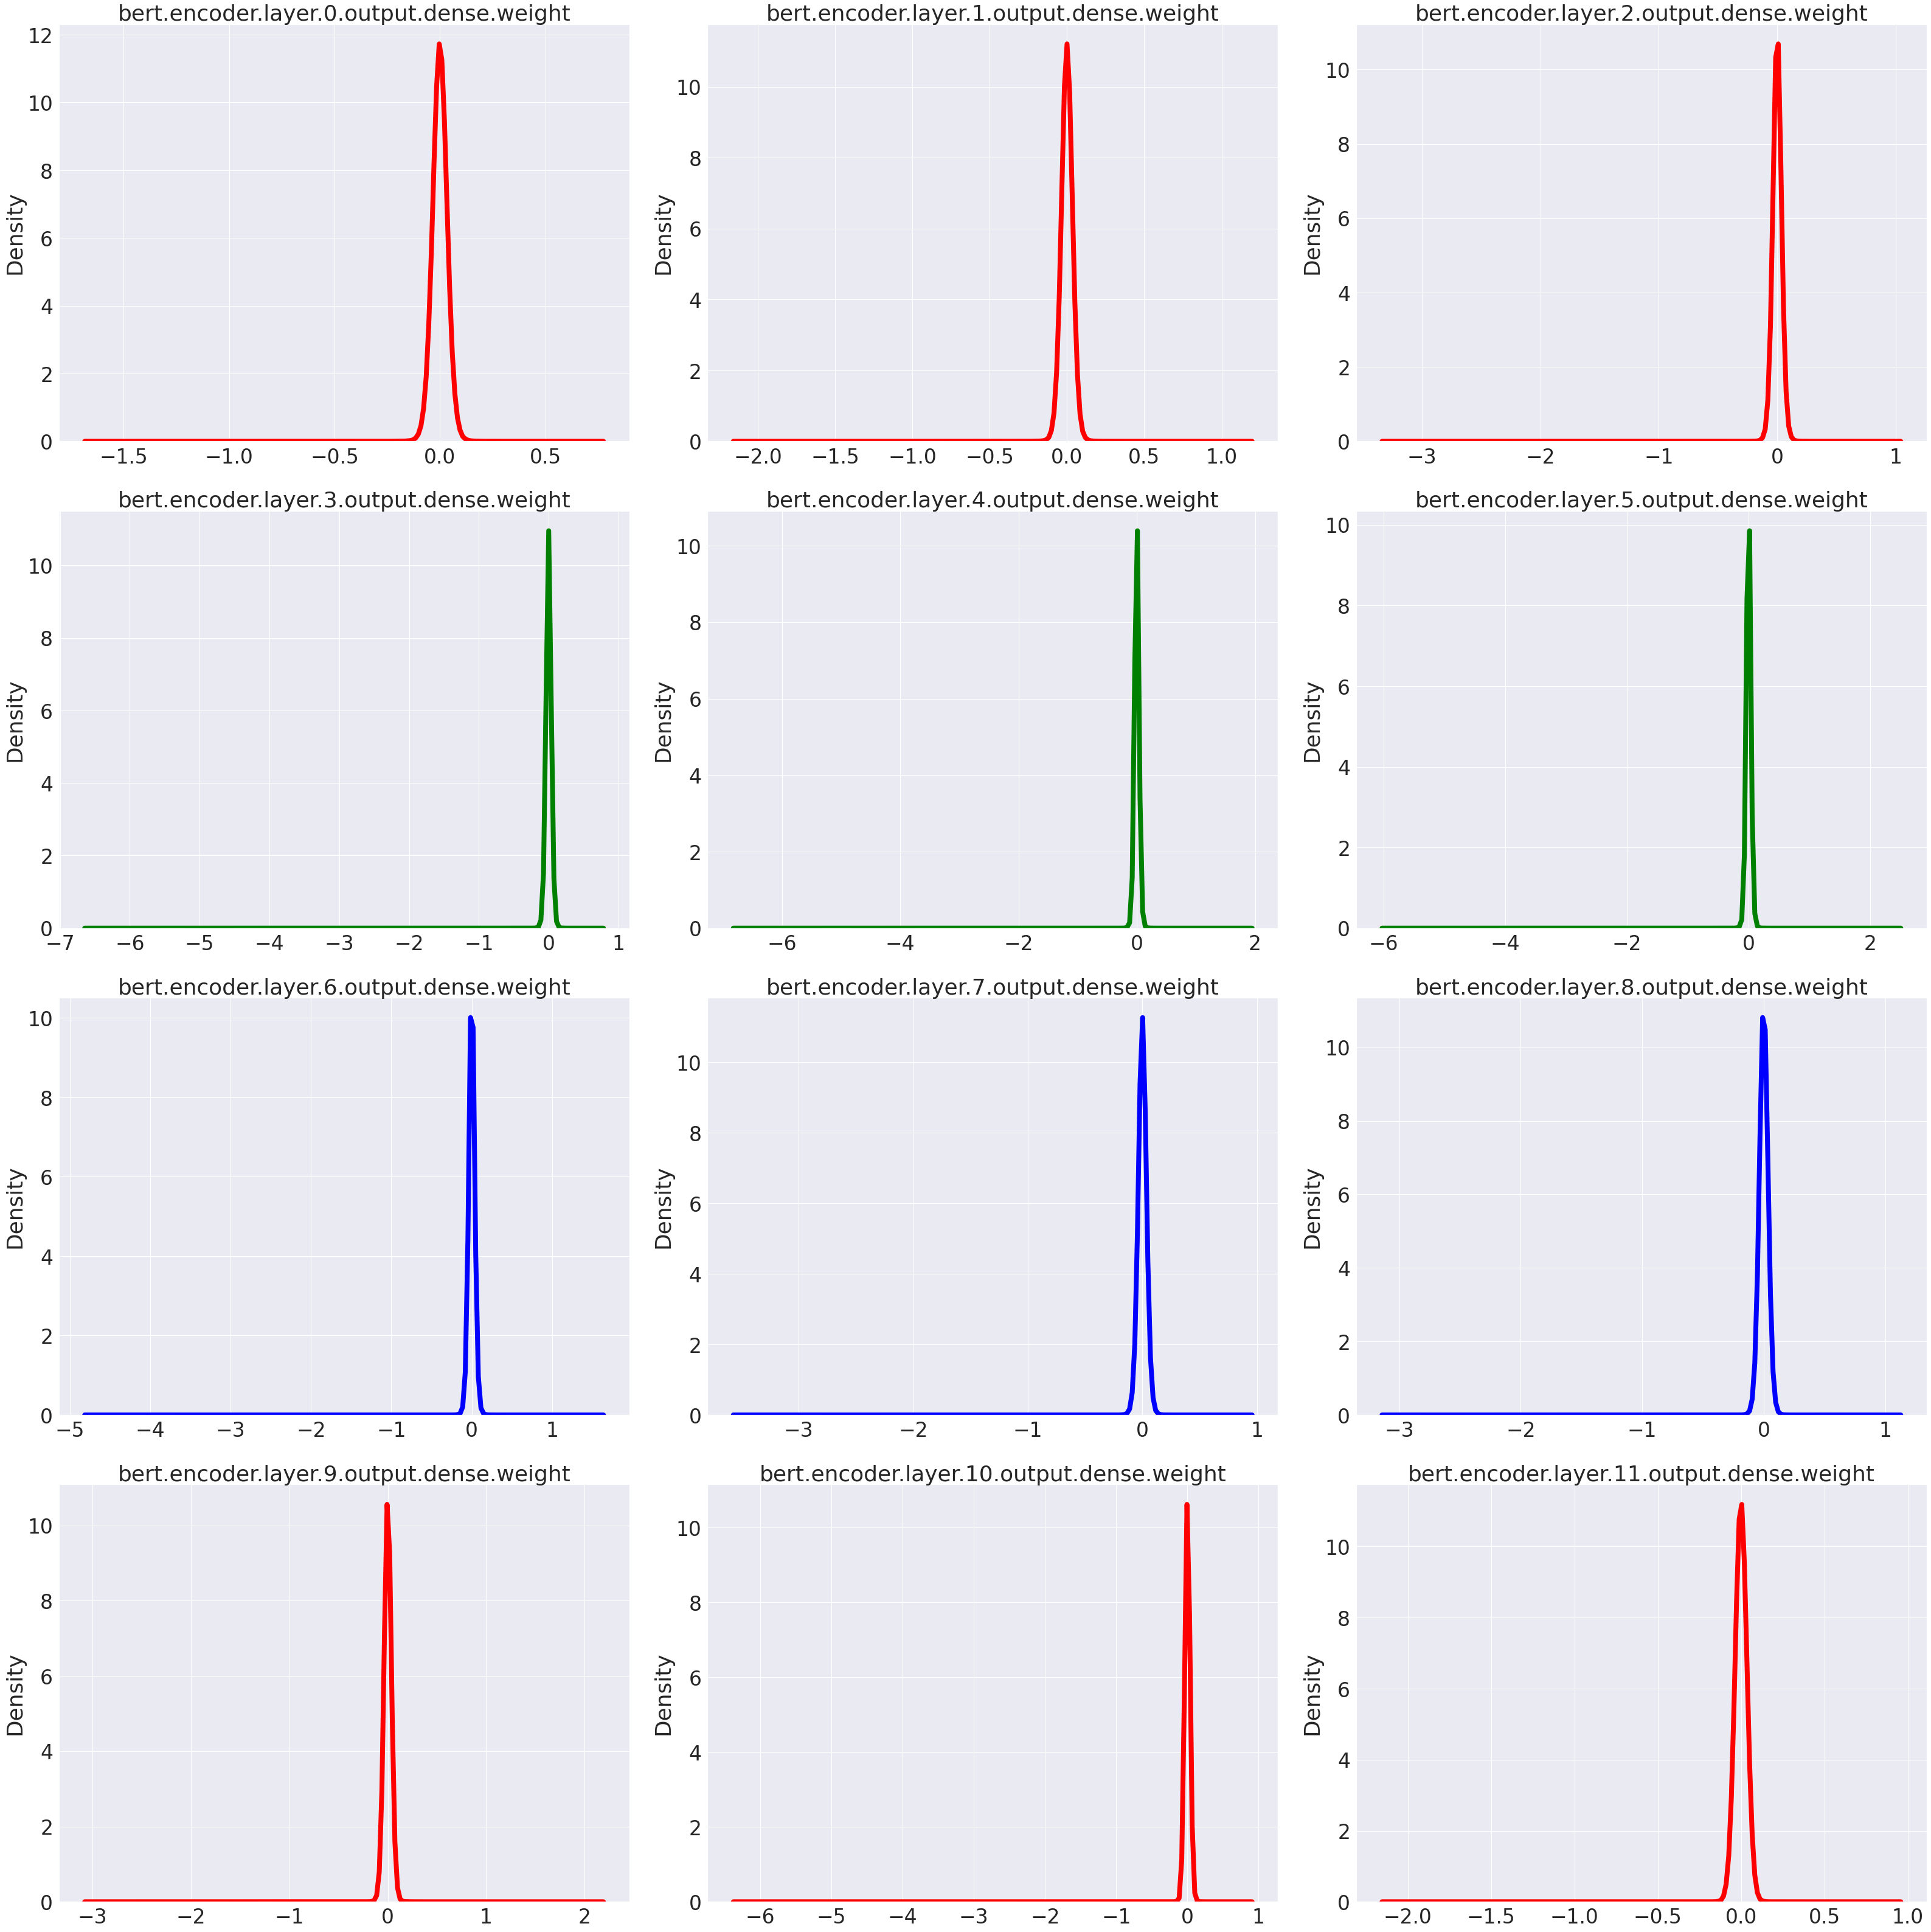

In [ ]:
layer_keys = [ 'bert.encoder.layer.{}.output.dense.weight'.format(i) for i in range(0, 12)]

h_args["method"] = plot_kde
h_args["method_kwargs"] = {"linewidth":8.0}
h_args["layer_keys"] = layer_keys
h_args["row_num"] = 4

layer_wise_summary(**h_args)

In [66]:
import torch
import numpy as np
sentence = ["The","elves","prepared","a","delicious","[MASK]","in","the","forest","to","celebrate","spring"]
tokenized_input = tokenizer(sentence,is_split_into_words=True,return_tensors='pt')
for each_id in tokenized_input["input_ids"]:
  print(tokenizer.decode(each_id))

model.eval()
with torch.no_grad():
  output = model(**tokenized_input)
print(output.keys())
print(output["attentions"][0].shape)


probs = torch.nn.functional.softmax(output.logits, dim=-1)
a = torch.argmax(probs, dim=-1)
print("inp = ", tokenized_input["input_ids"])
print("a = ",a)
mask_id = torch.where(tokenized_input["input_ids"]==103)
print("mask_id = ", mask_id[1][0])

print("Predicted = ", tokenizer.decode( a[0][mask_id[1][0].item()]))

[CLS] the elves prepared a delicious [MASK] in the forest to celebrate spring [SEP]
odict_keys(['logits', 'hidden_states', 'attentions'])
torch.Size([1, 12, 14, 14])
inp =  tensor([[  101,  1996, 16980,  4810,  1037, 12090,   103,  1999,  1996,  3224,
          2000,  8439,  3500,   102]])
a =  tensor([[ 1012,  1996, 16980,  4810,  1037, 12090,  9831,  1999,  1996,  3224,
          2000,  8439,  1012,  1012]])
mask_id =  tensor(6)
Predicted =  feast


In [ ]:
attentions = output["attentions"] #Shape is 12, 1, 12, 14, 14
print(attentions[0].shape)                #Attn layers, batch size, attn heads, #tokens, #tokens

torch.Size([1, 12, 14, 14])


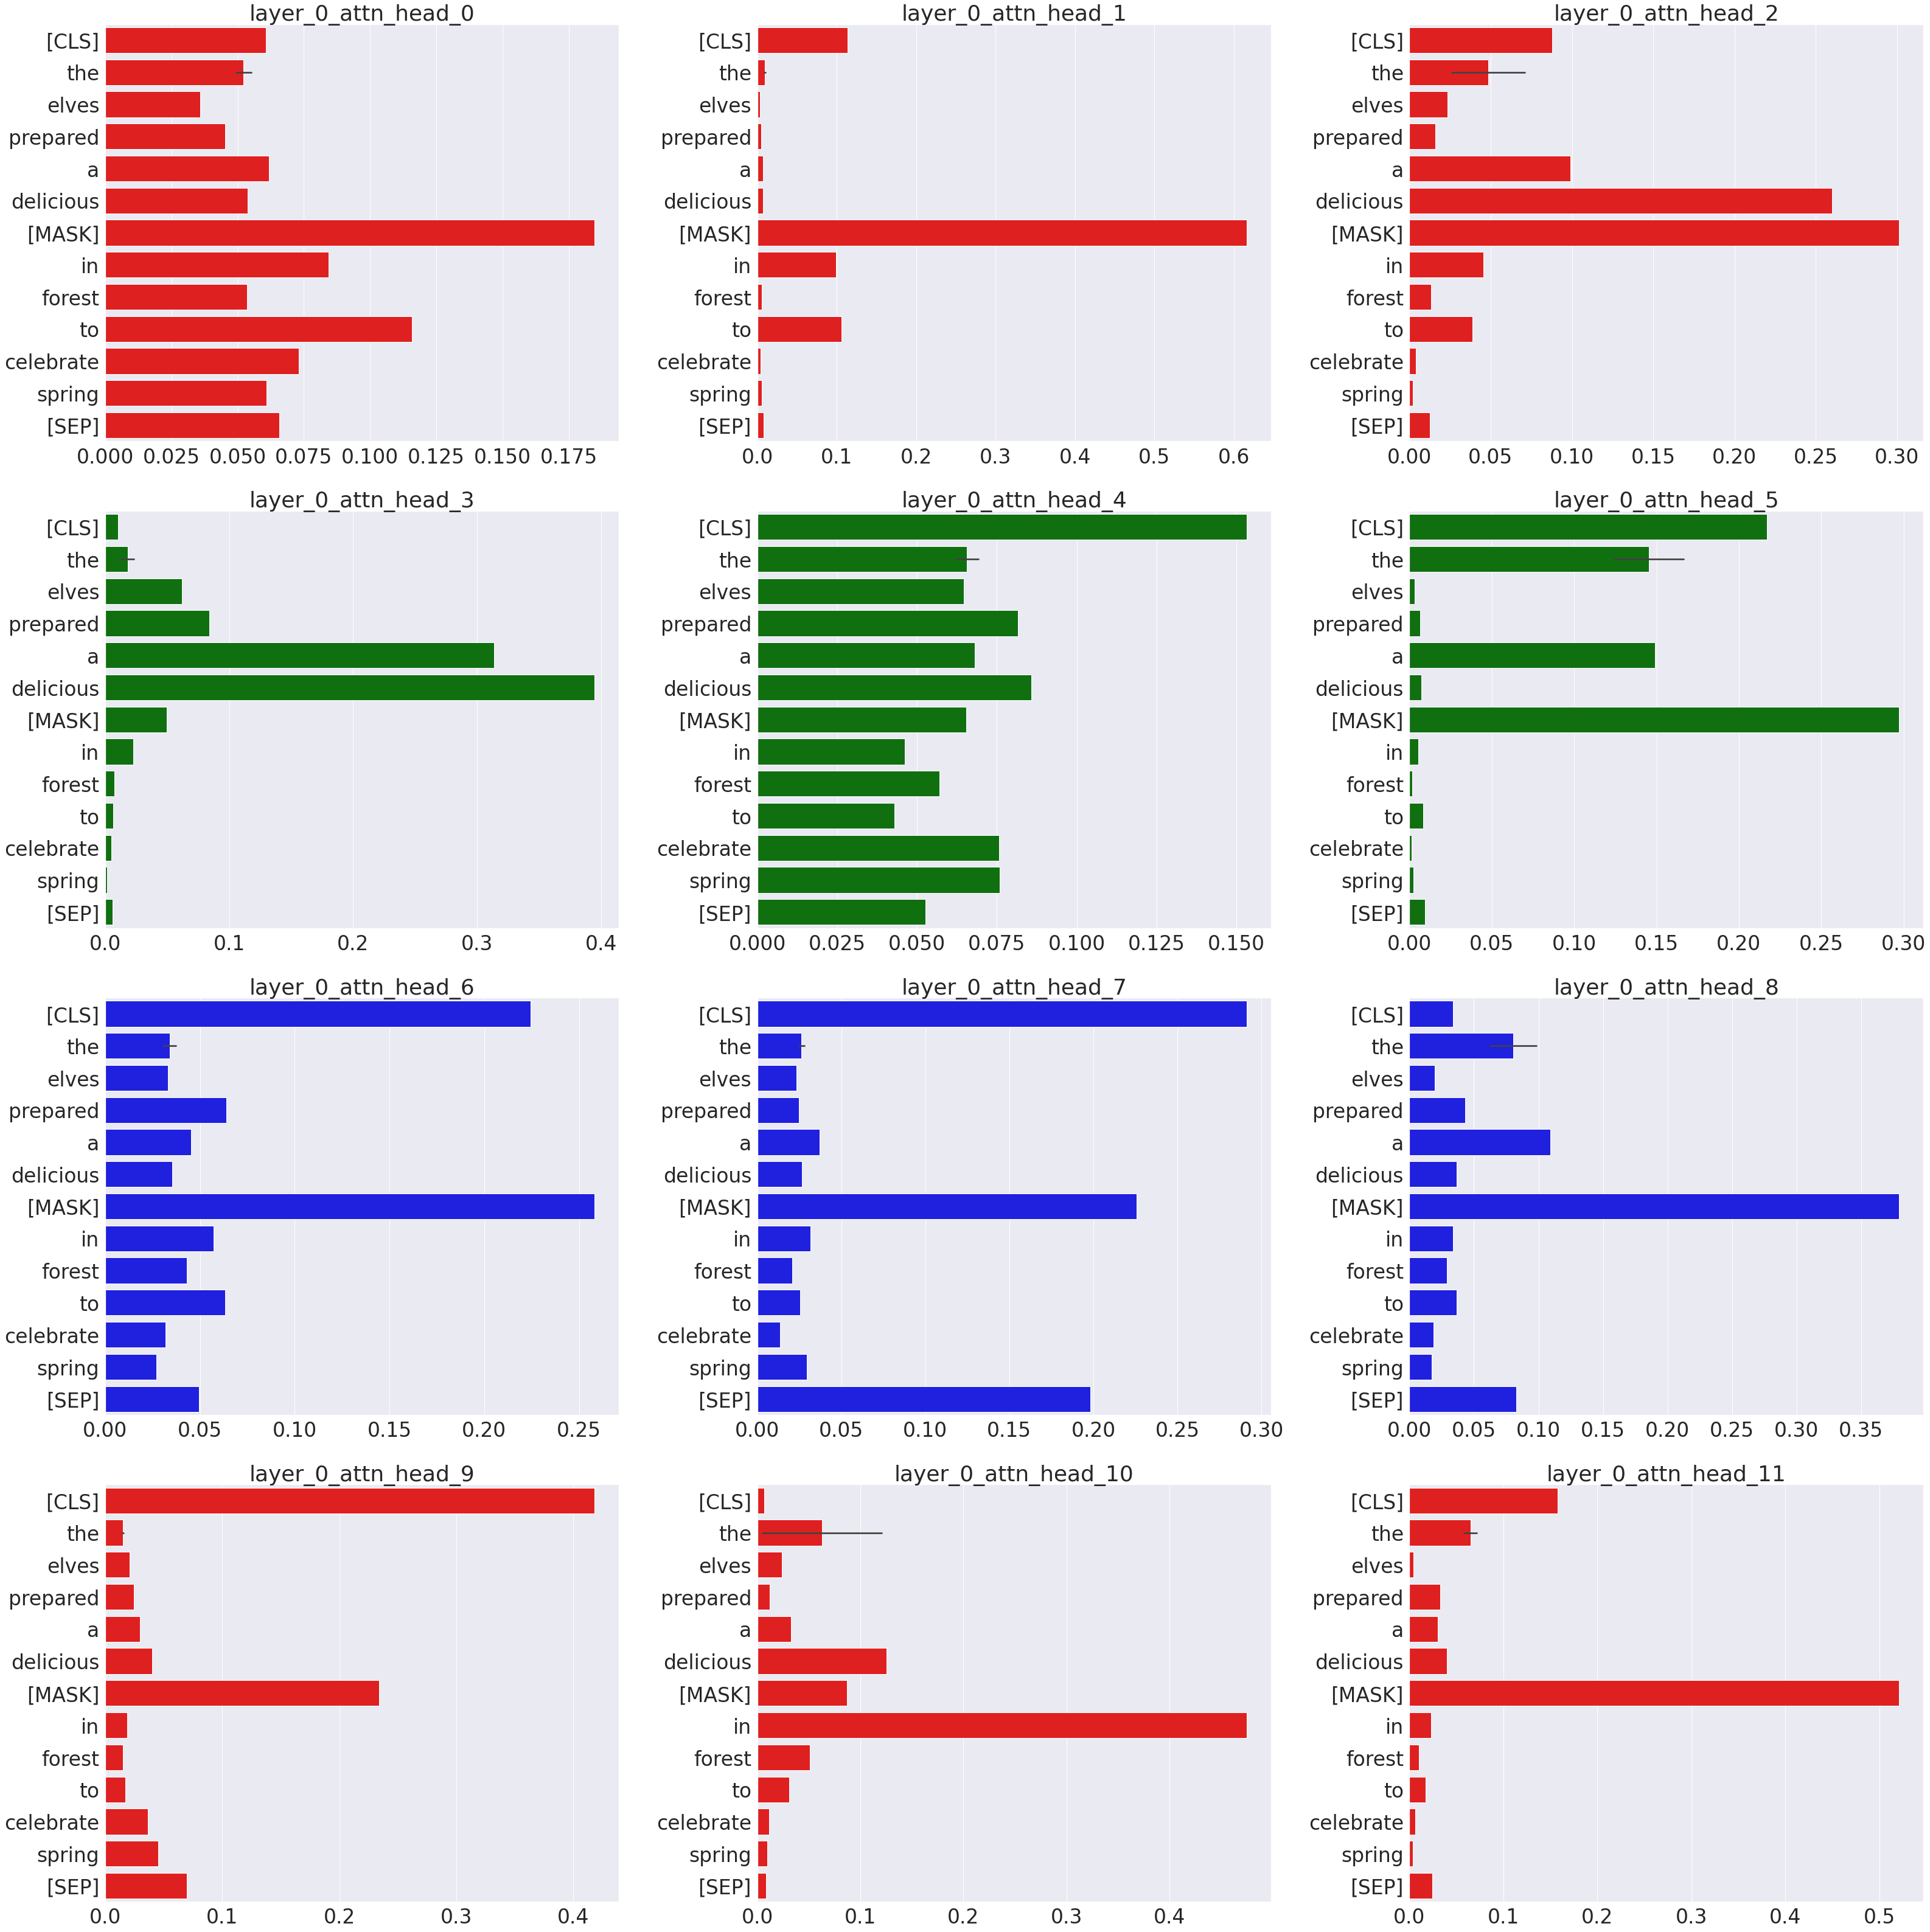

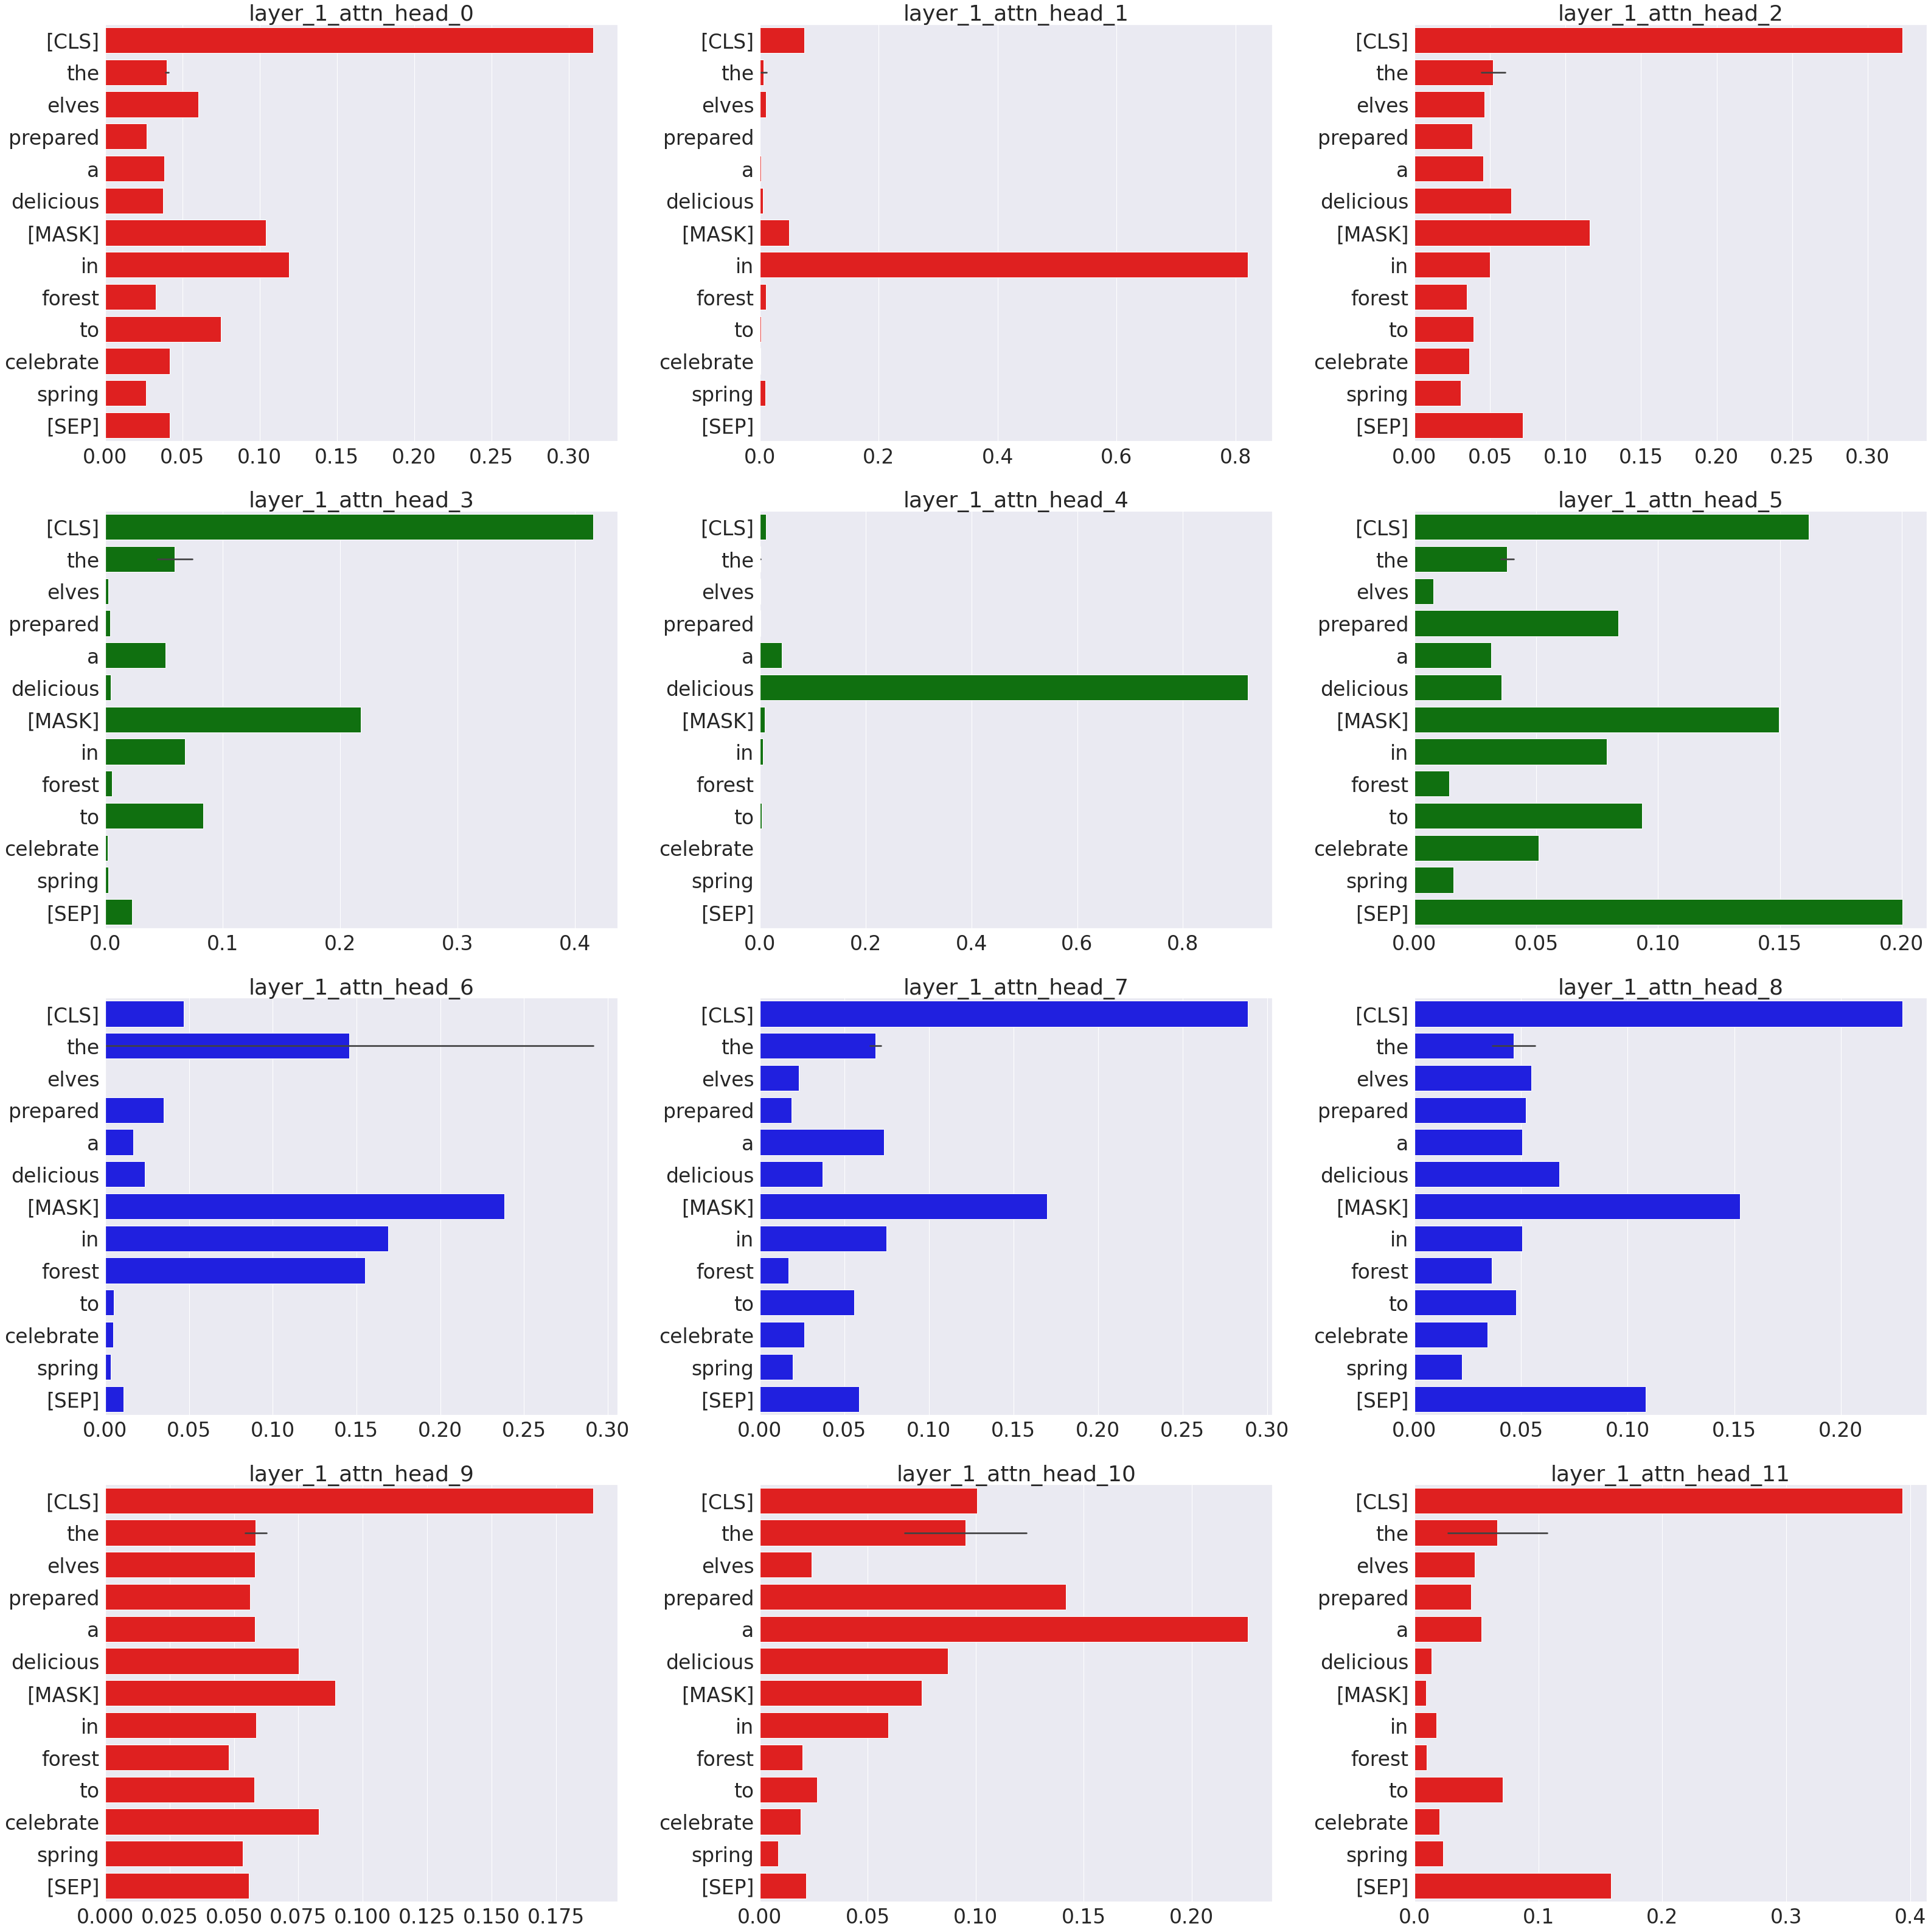

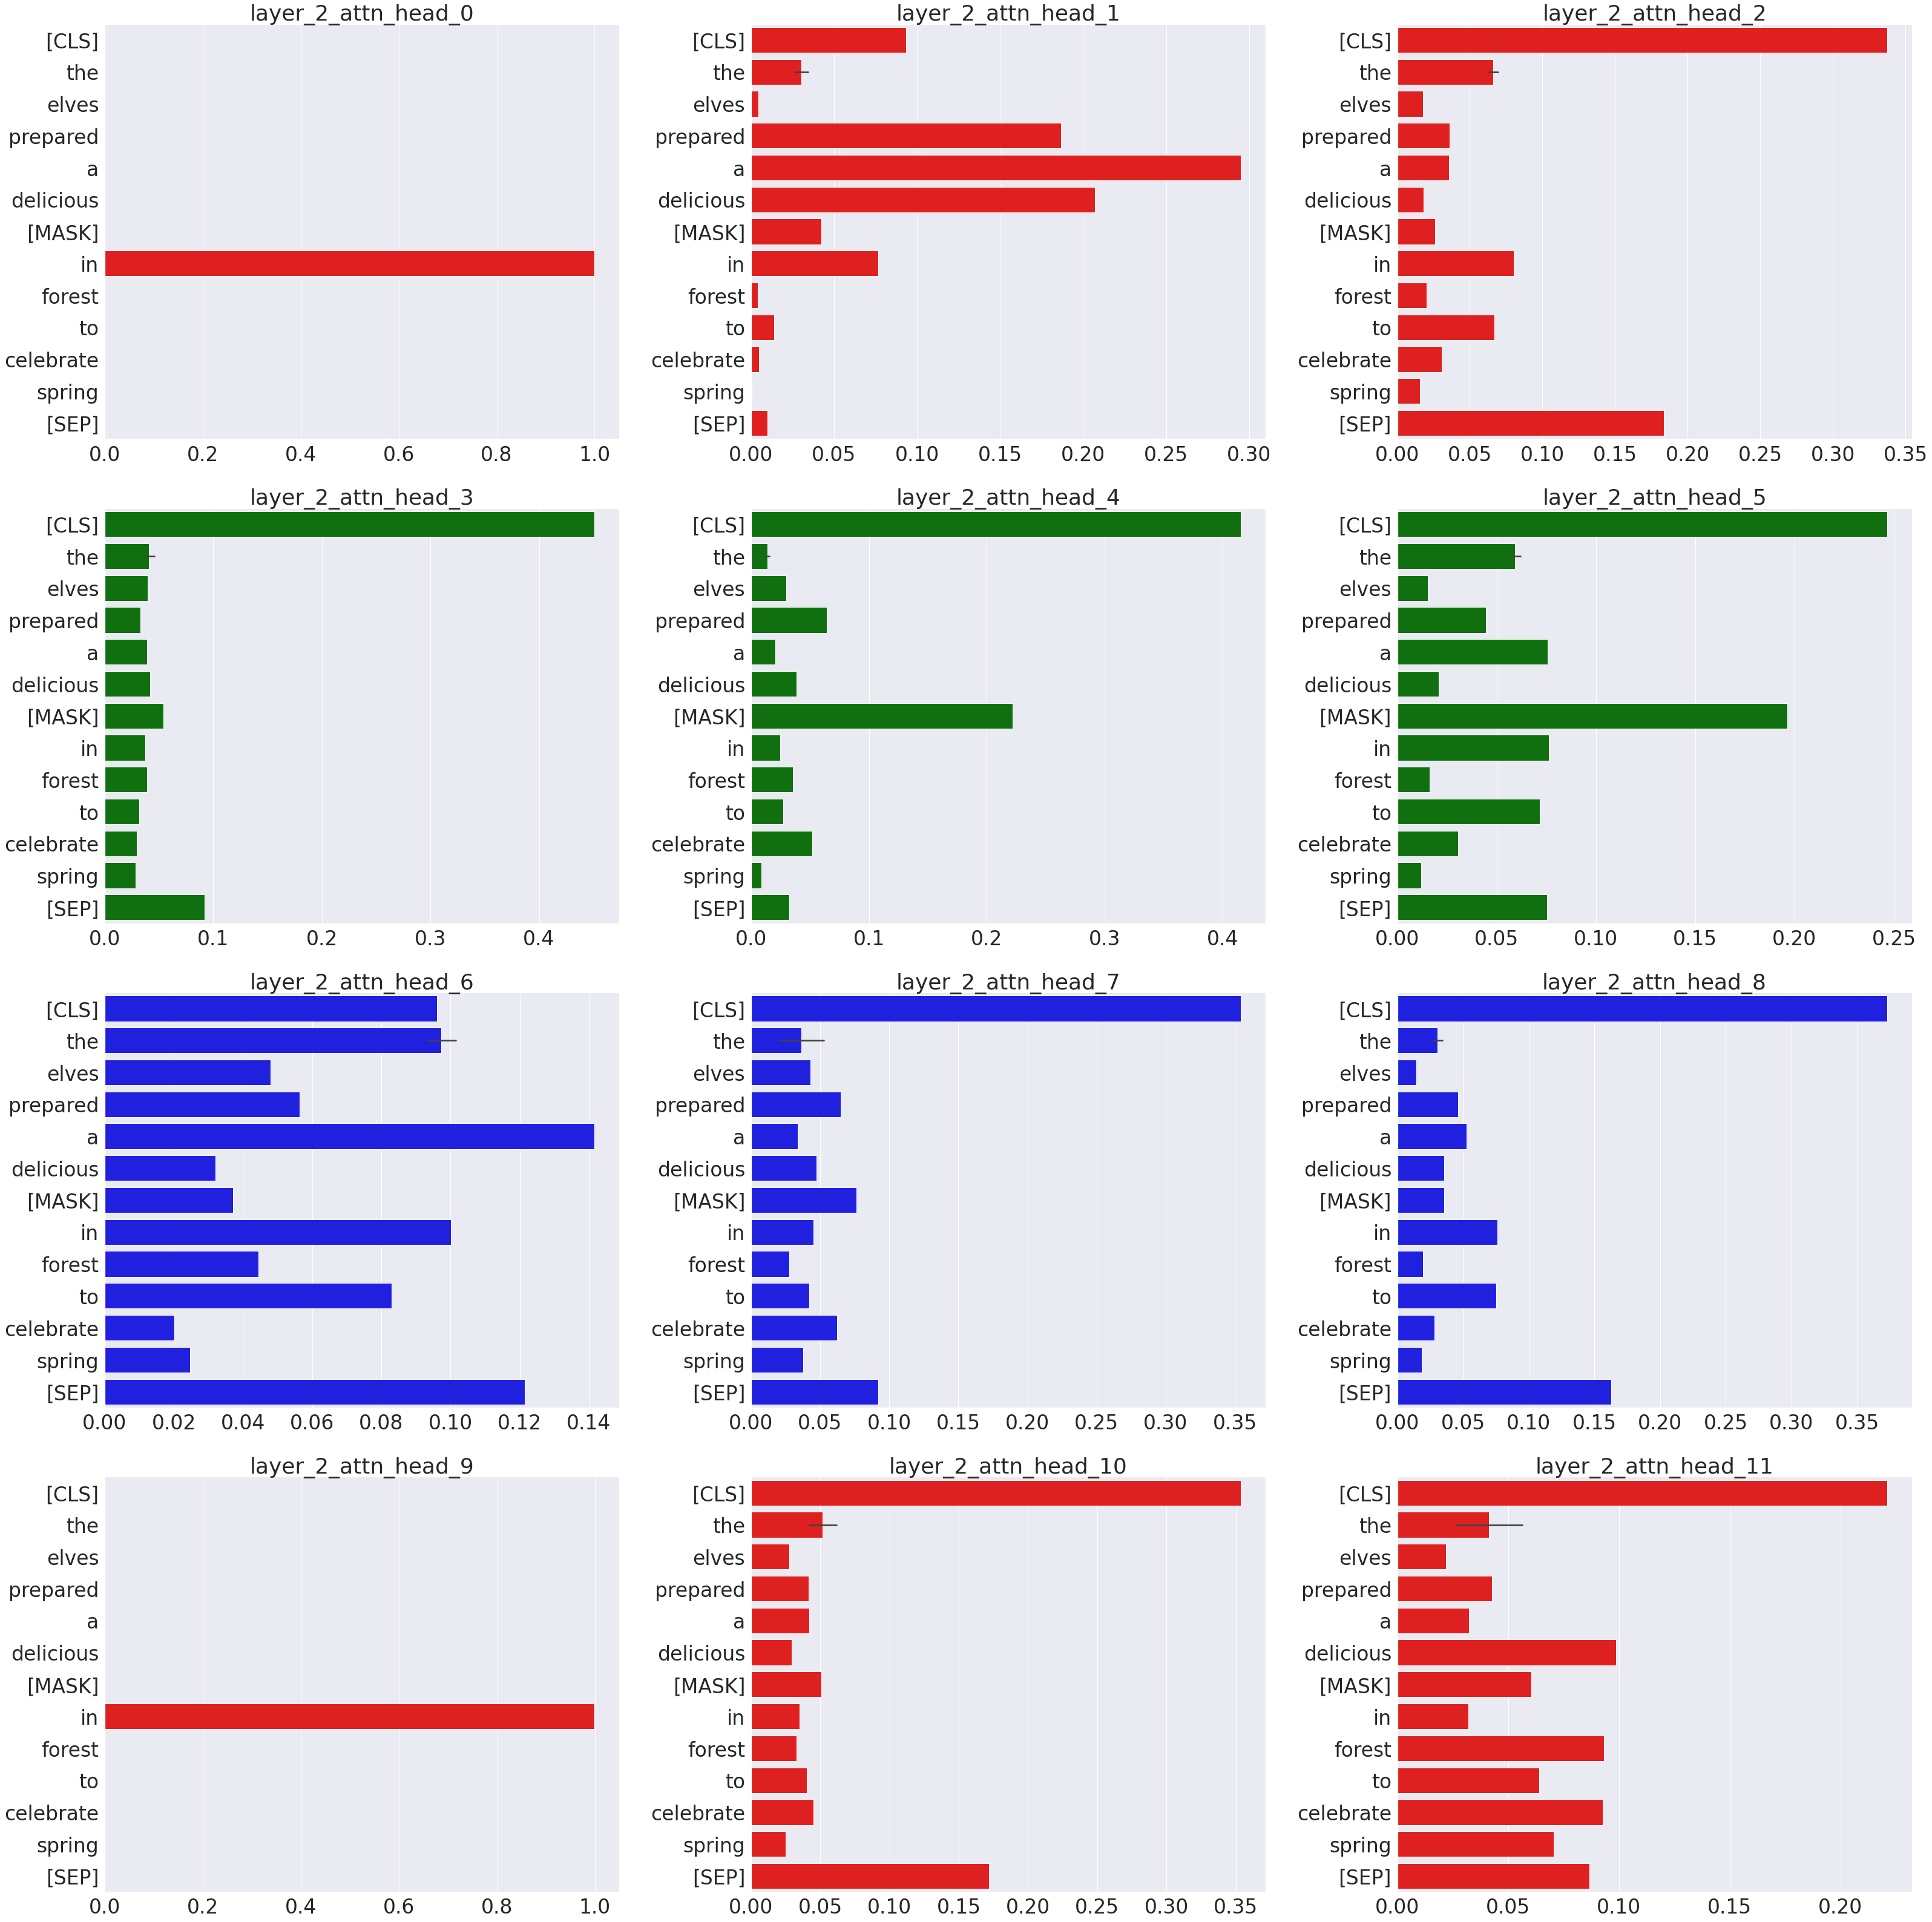

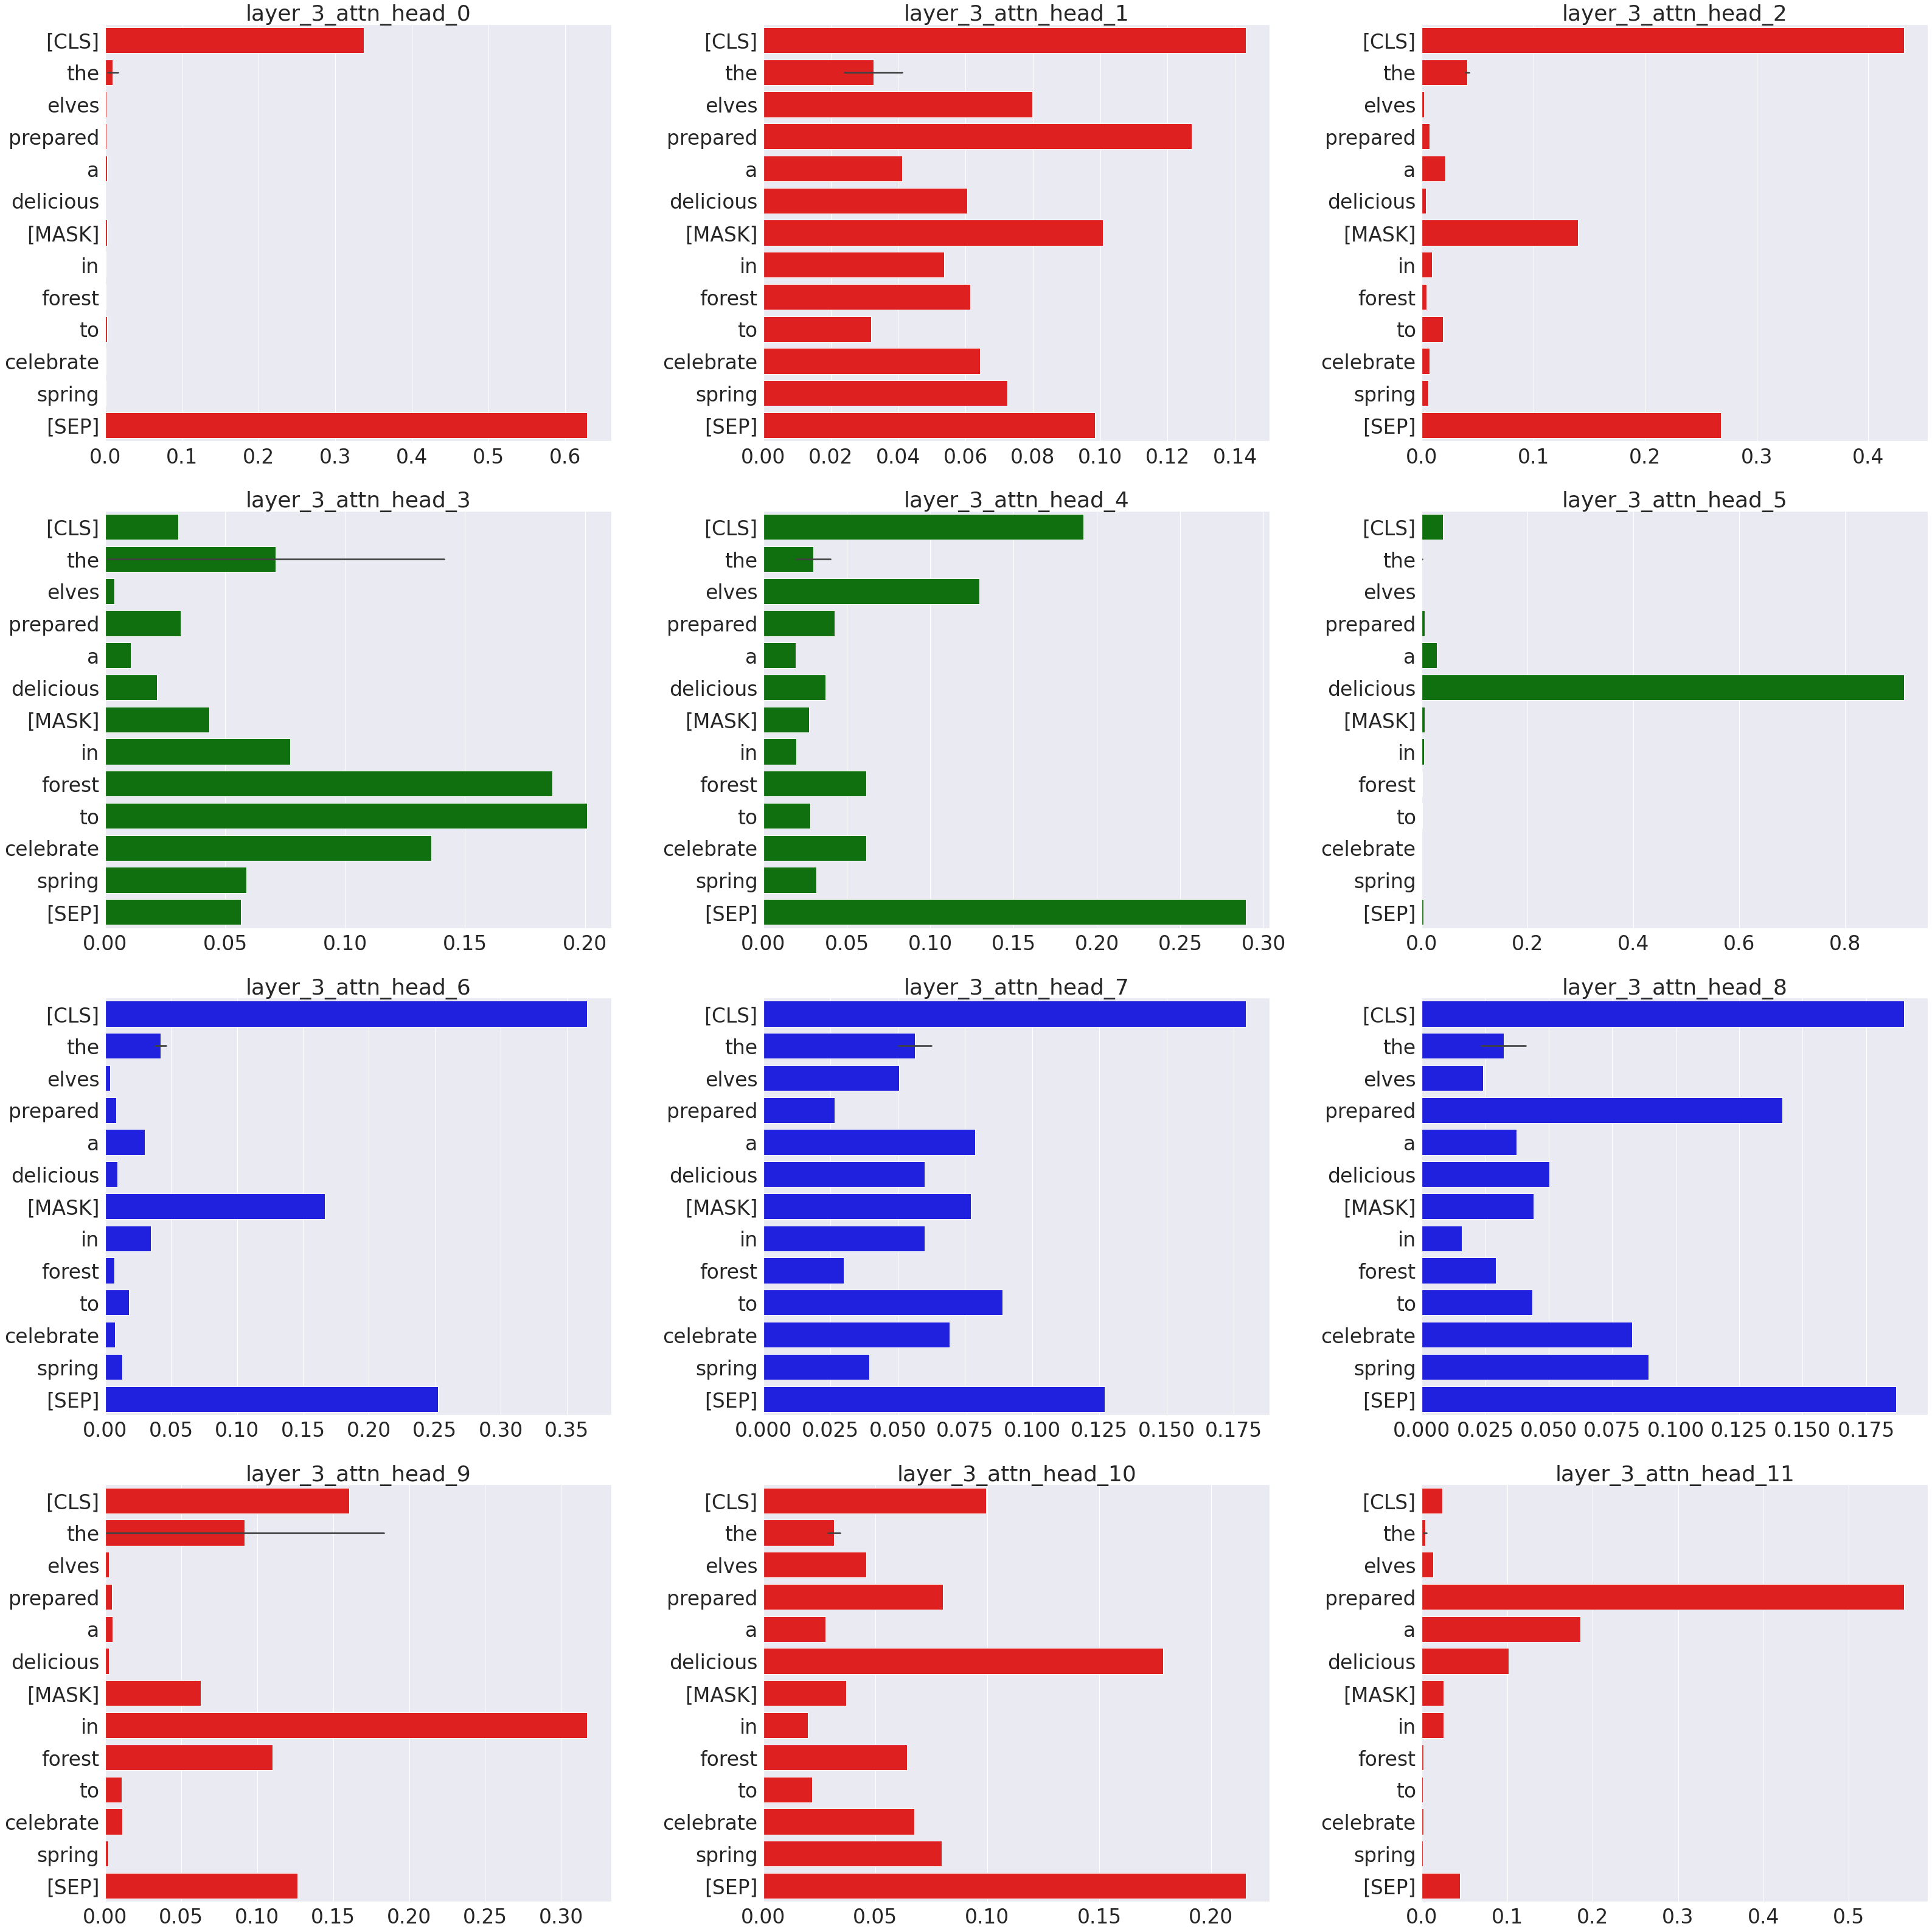

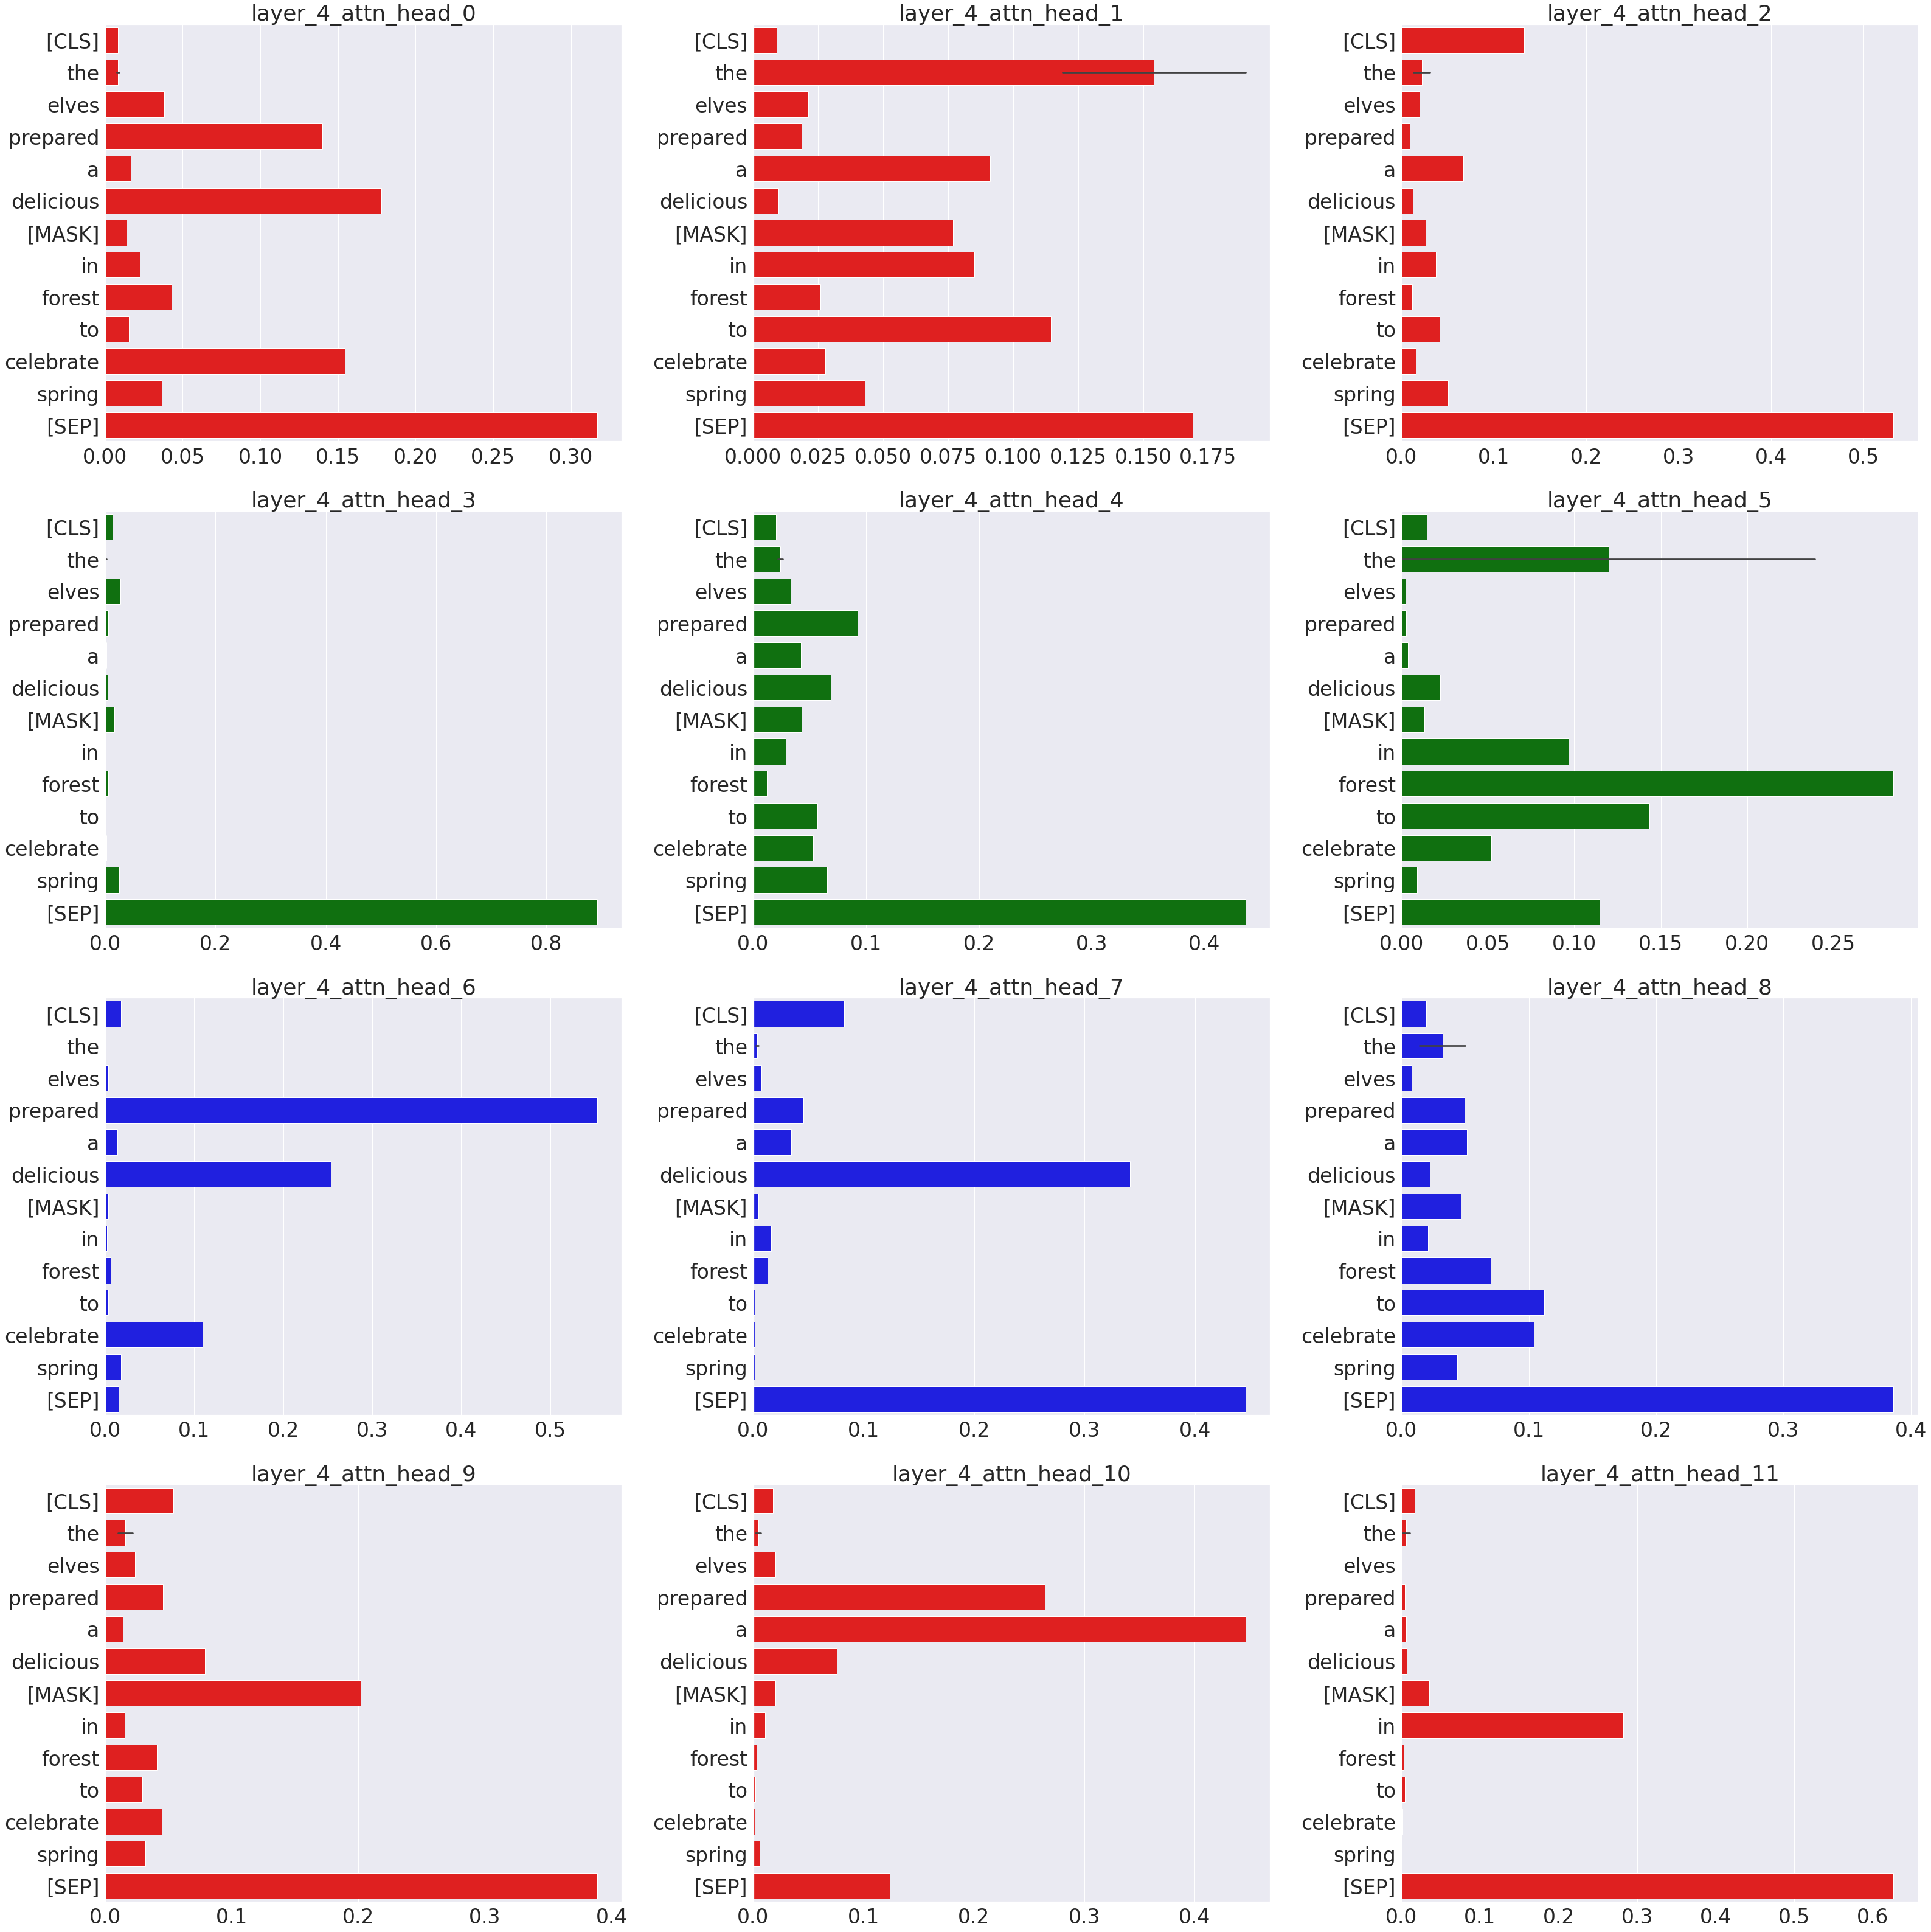

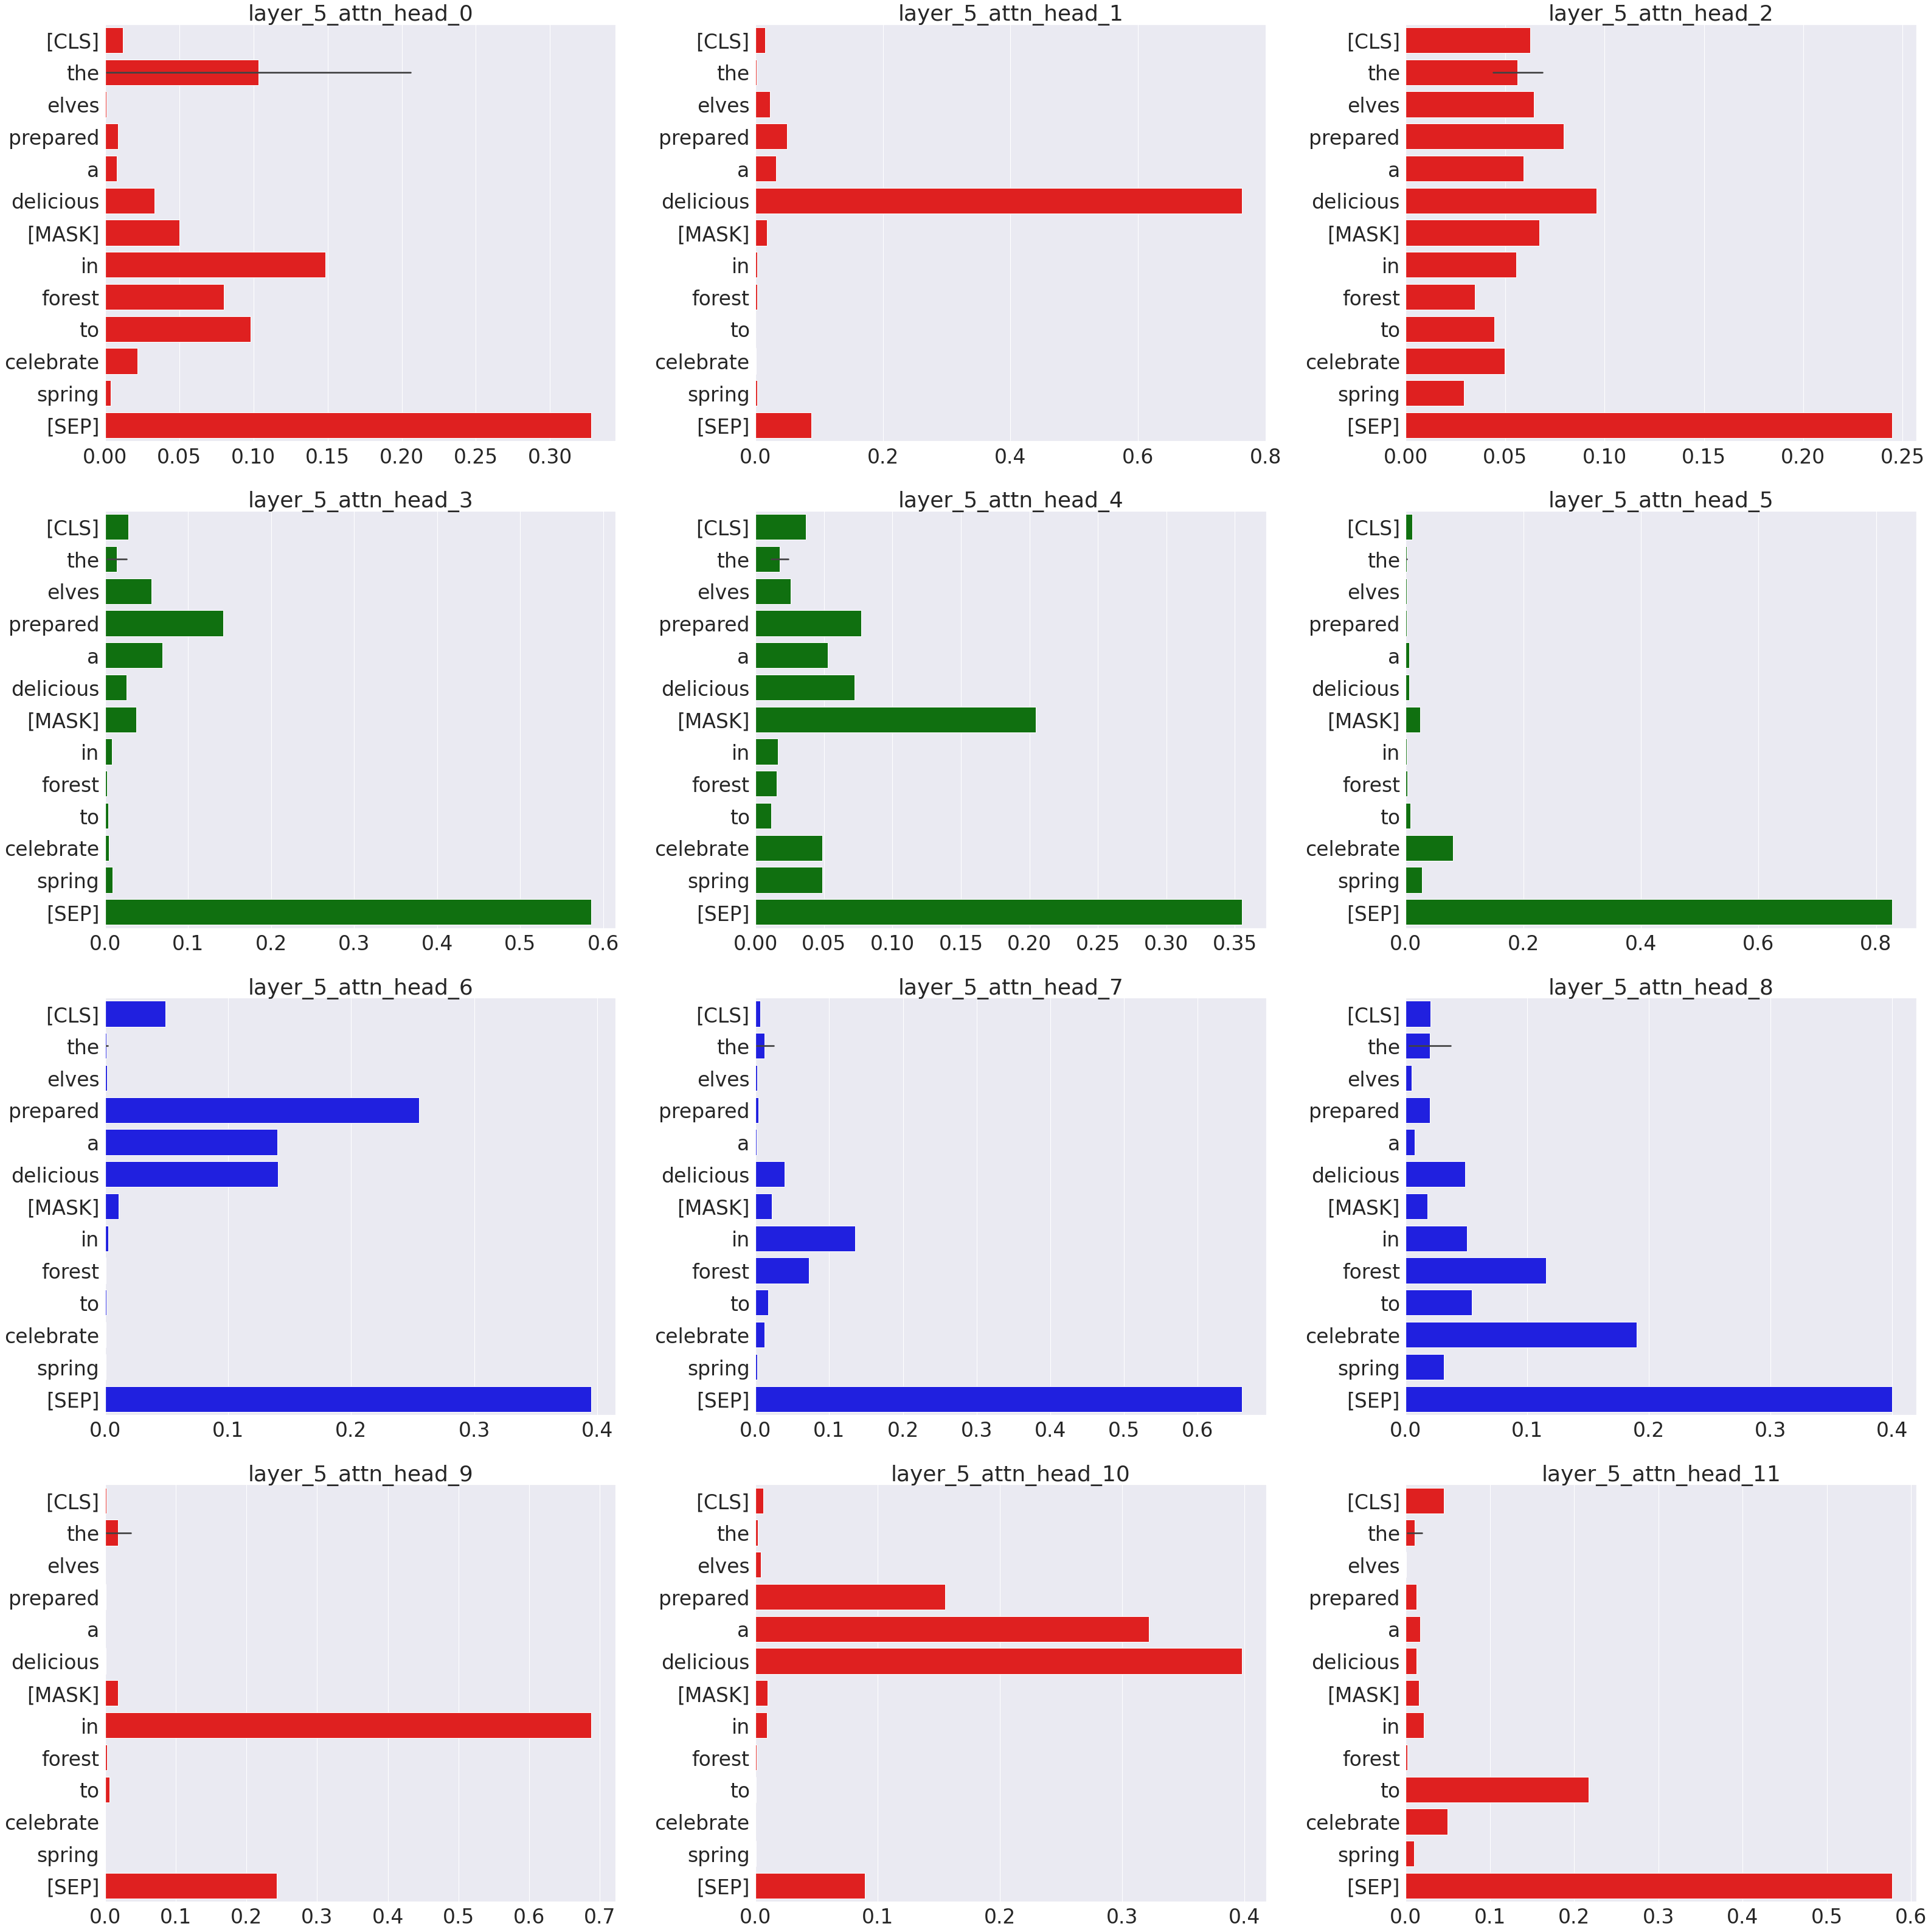

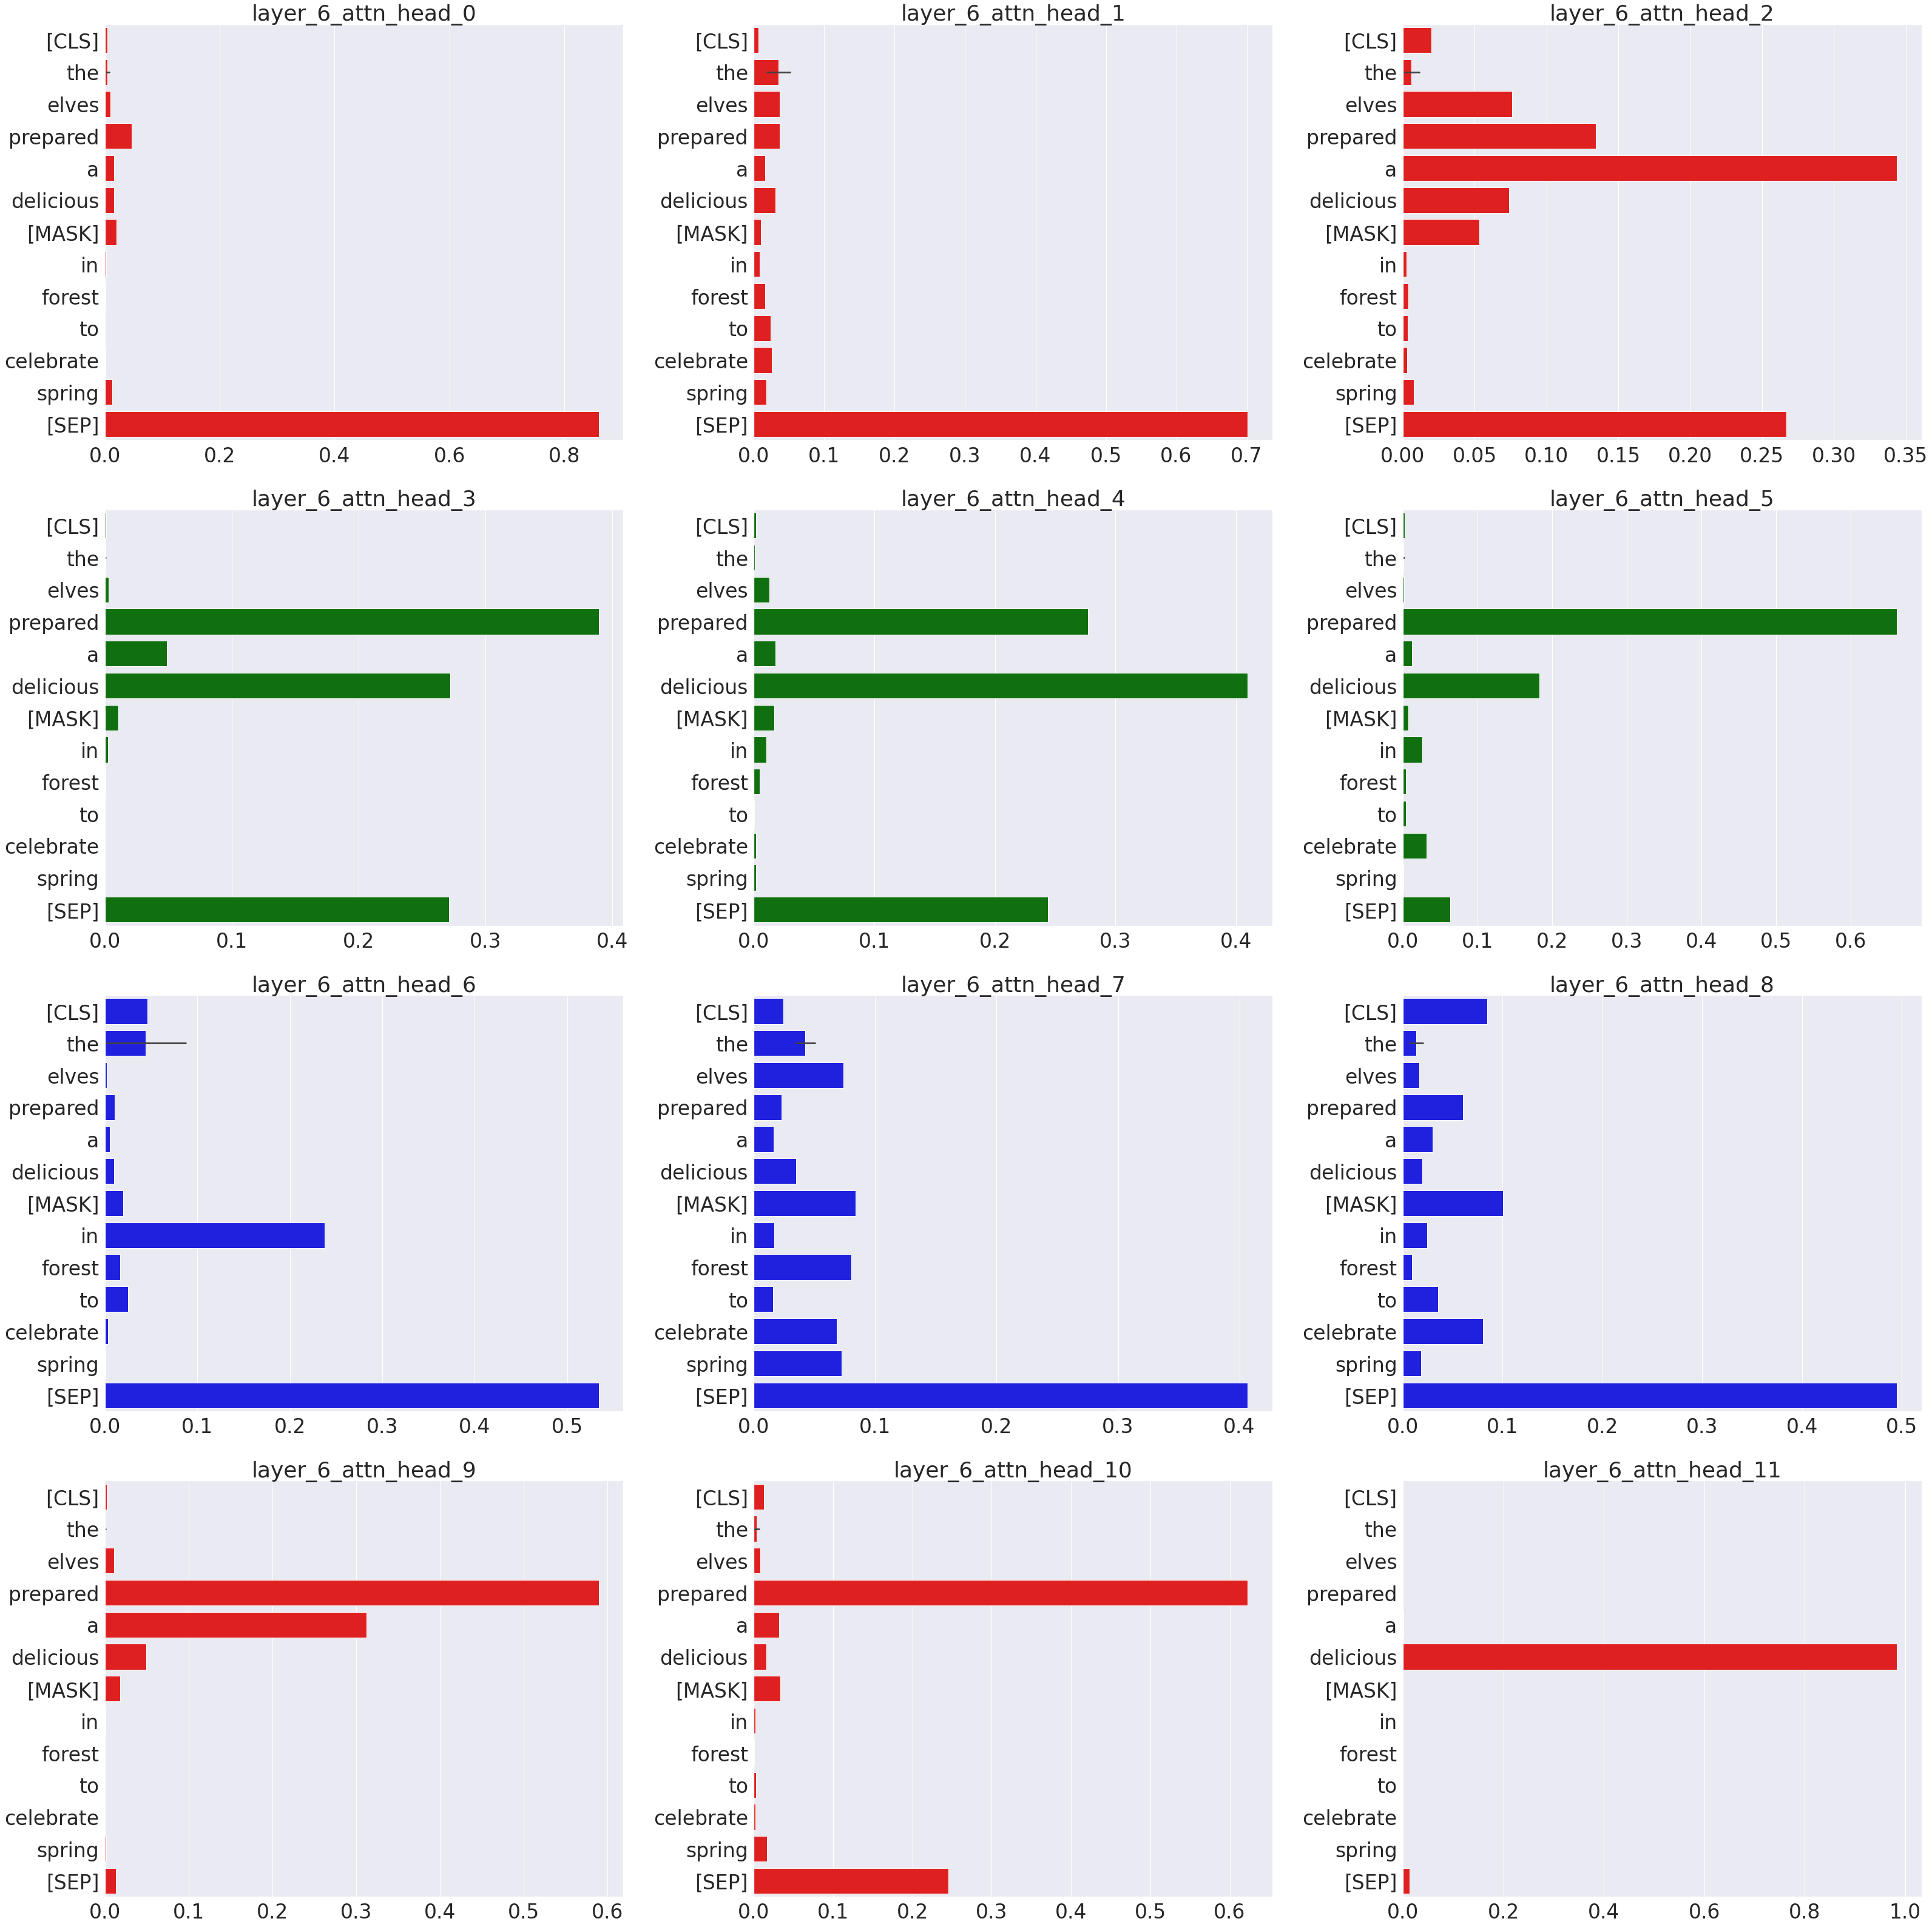

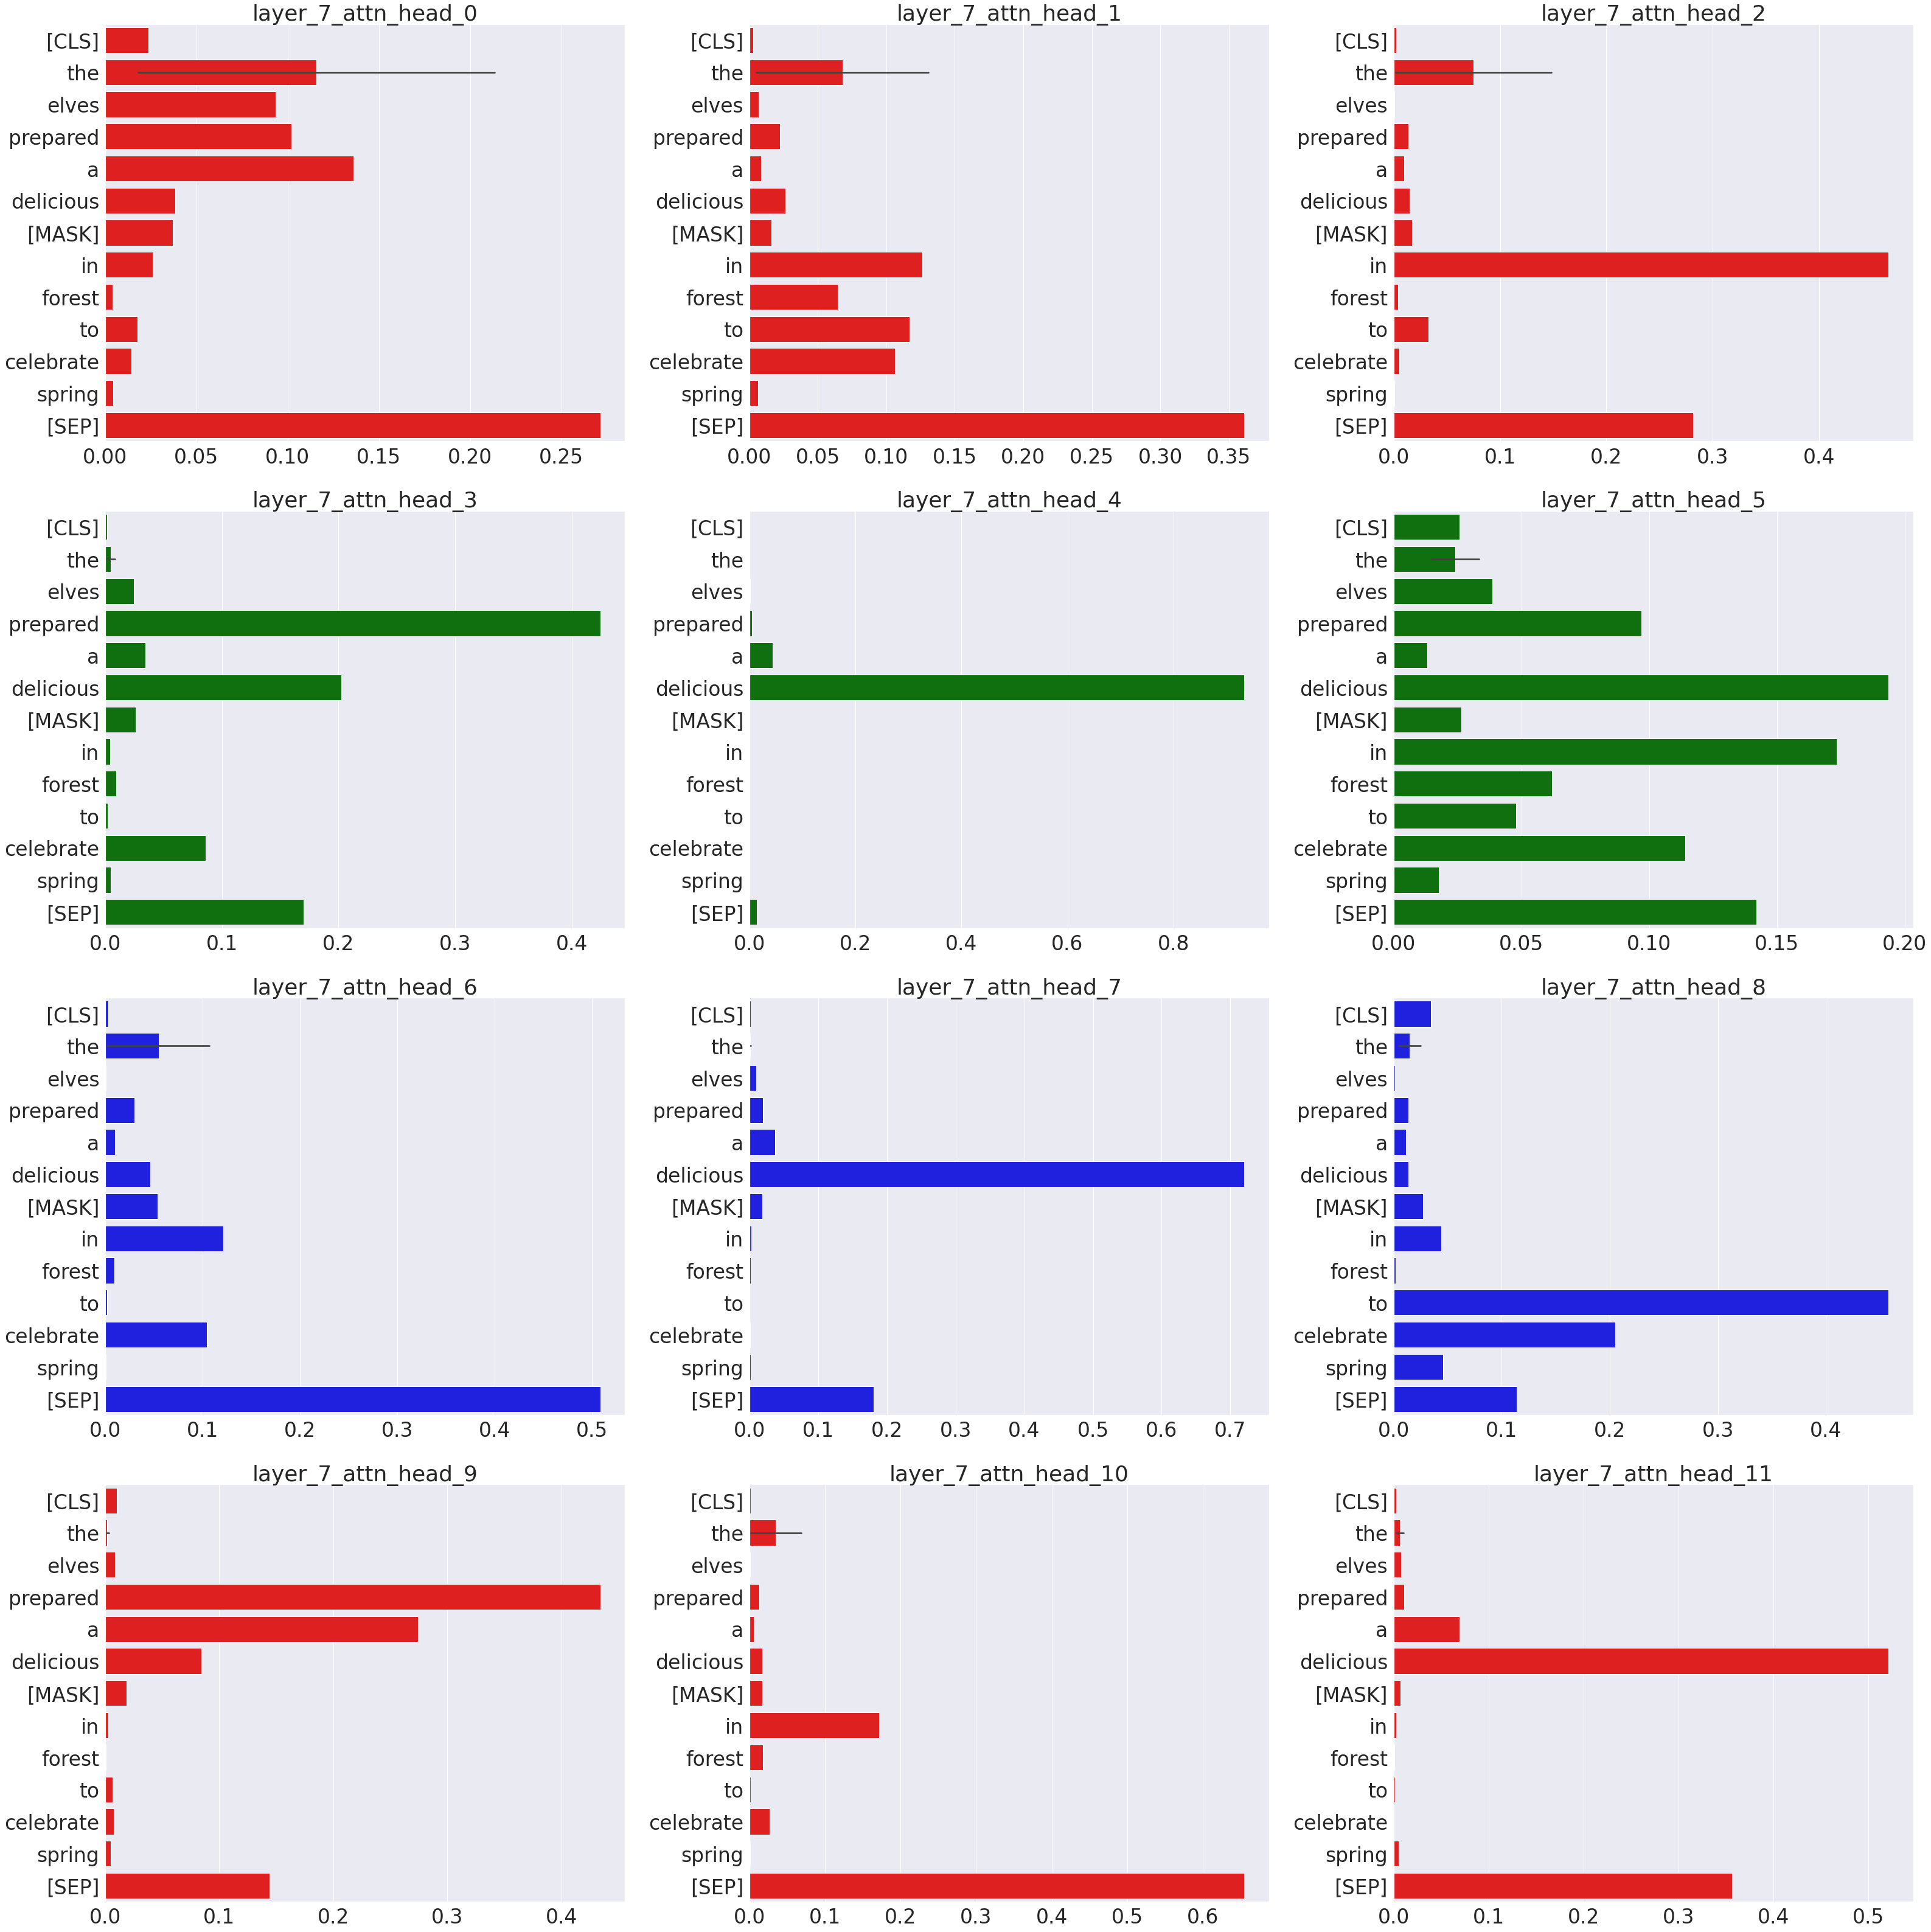

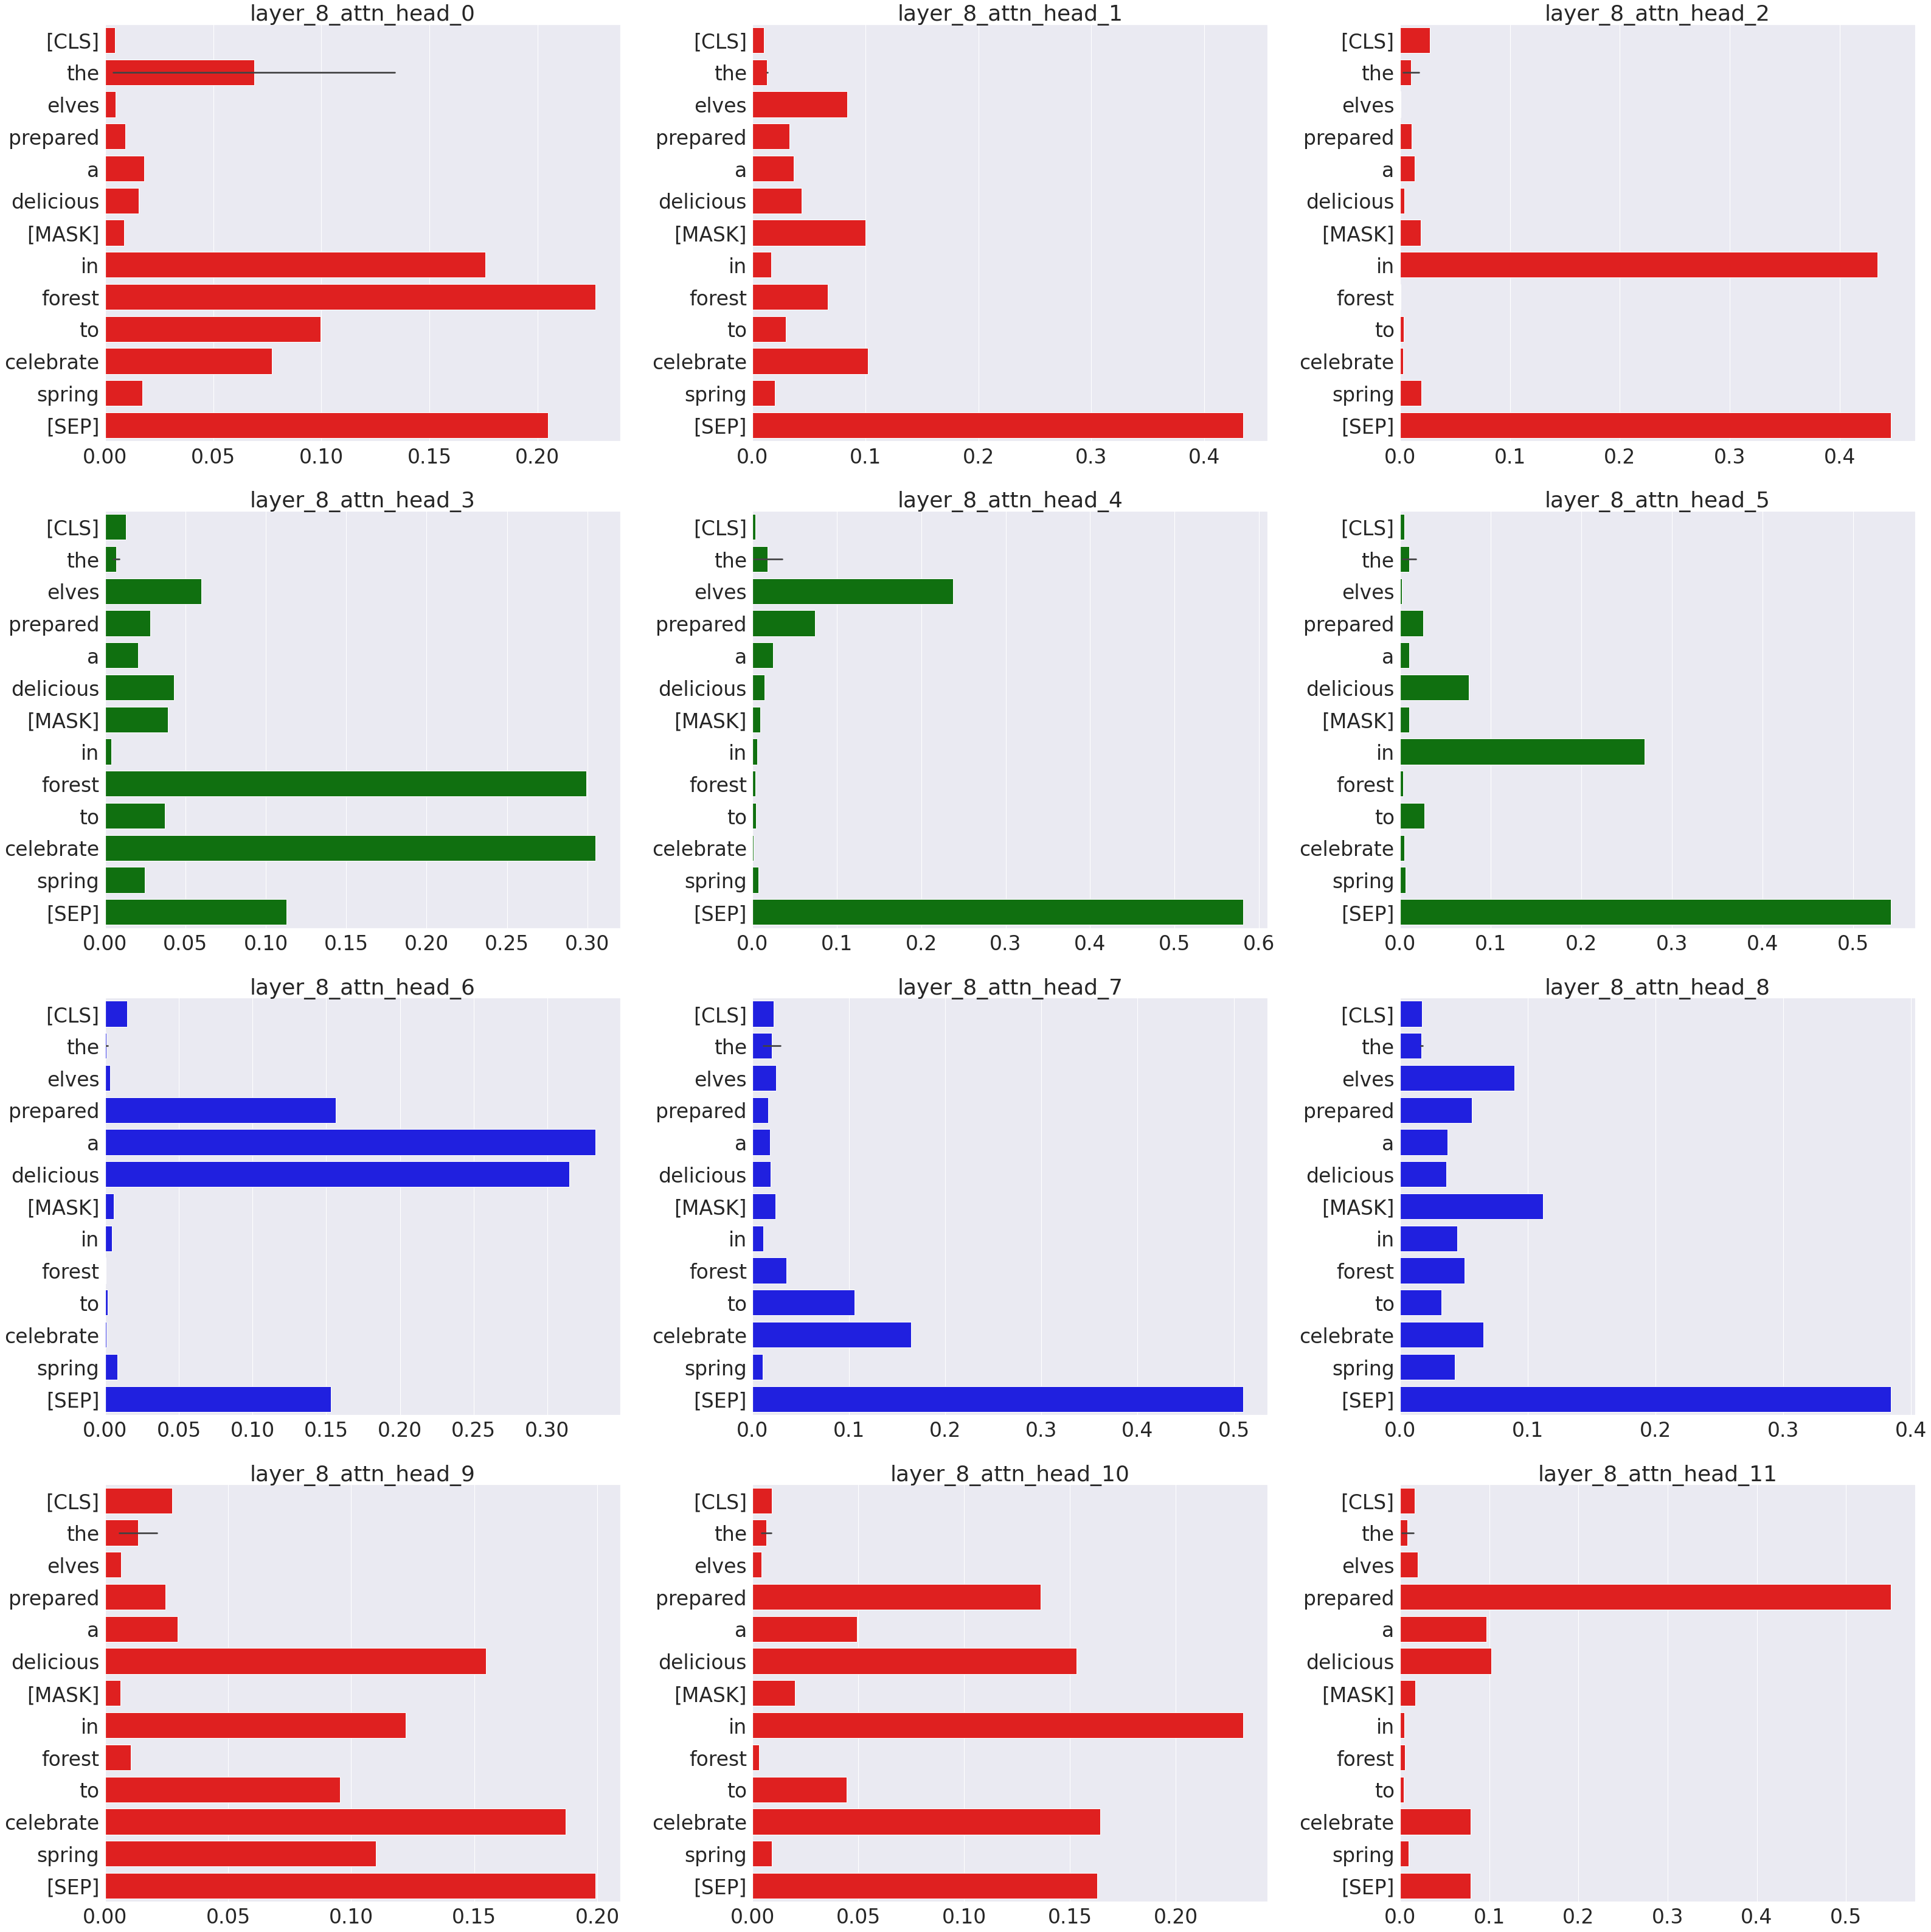

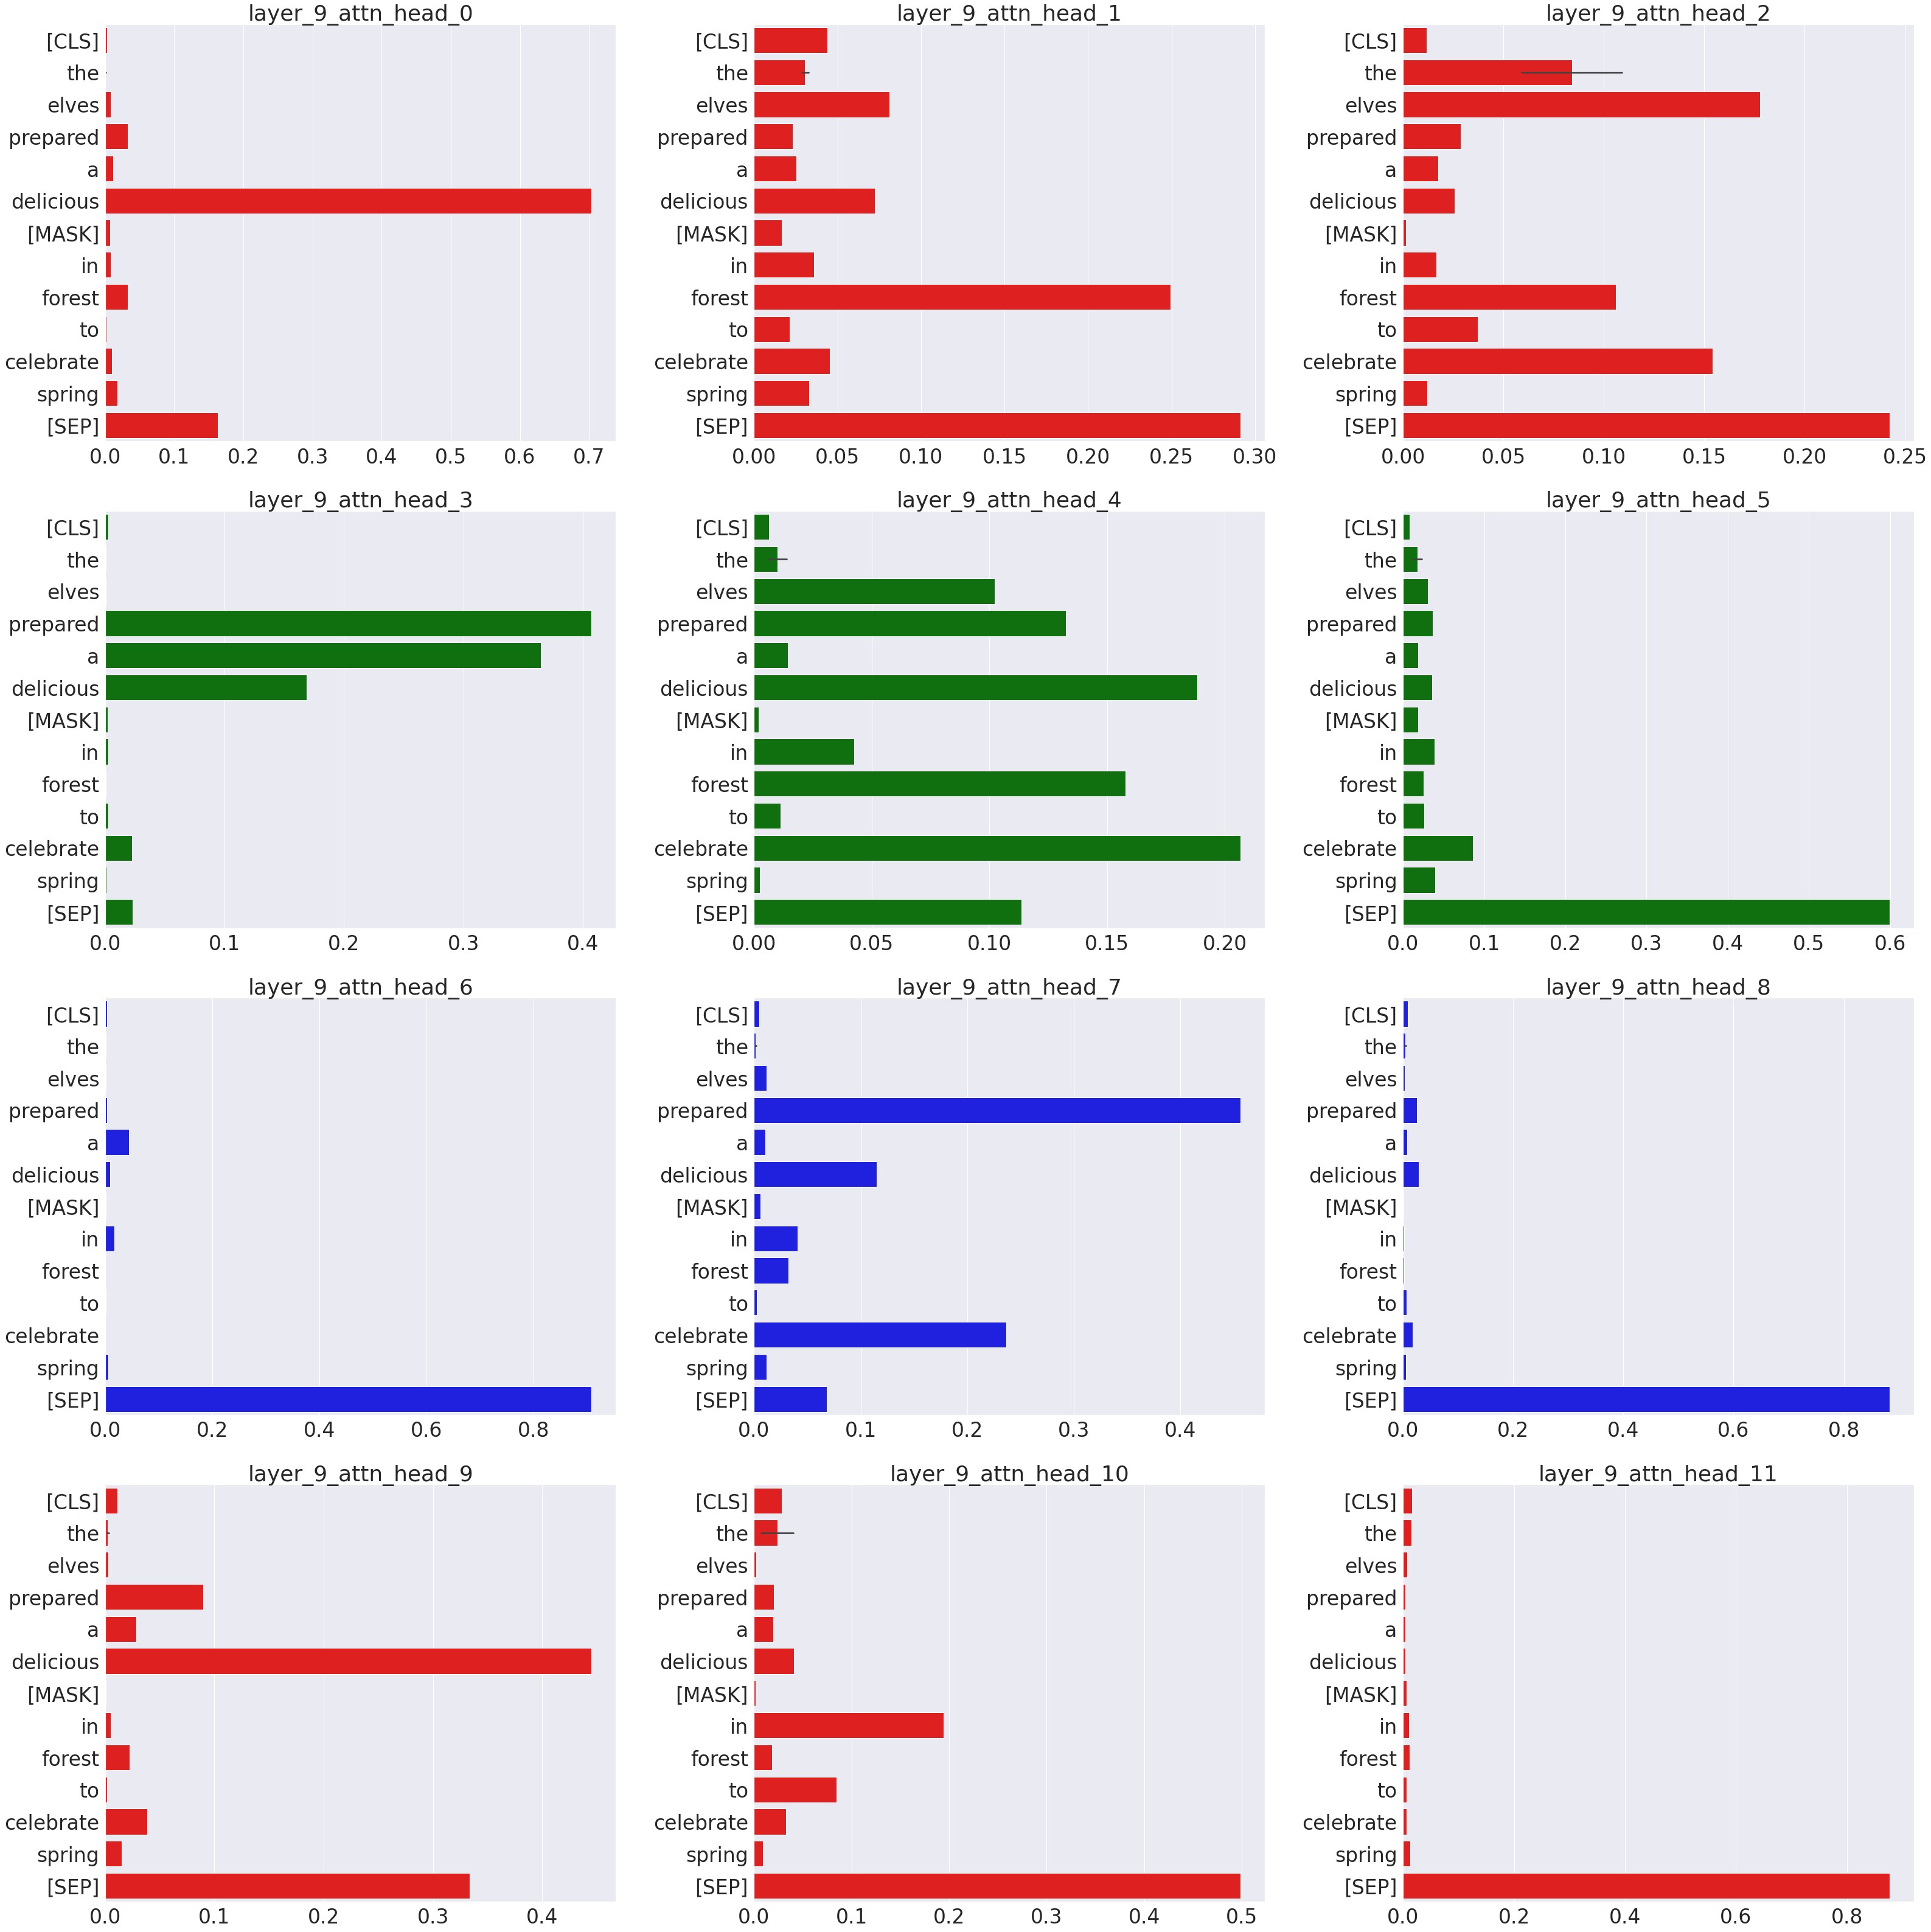

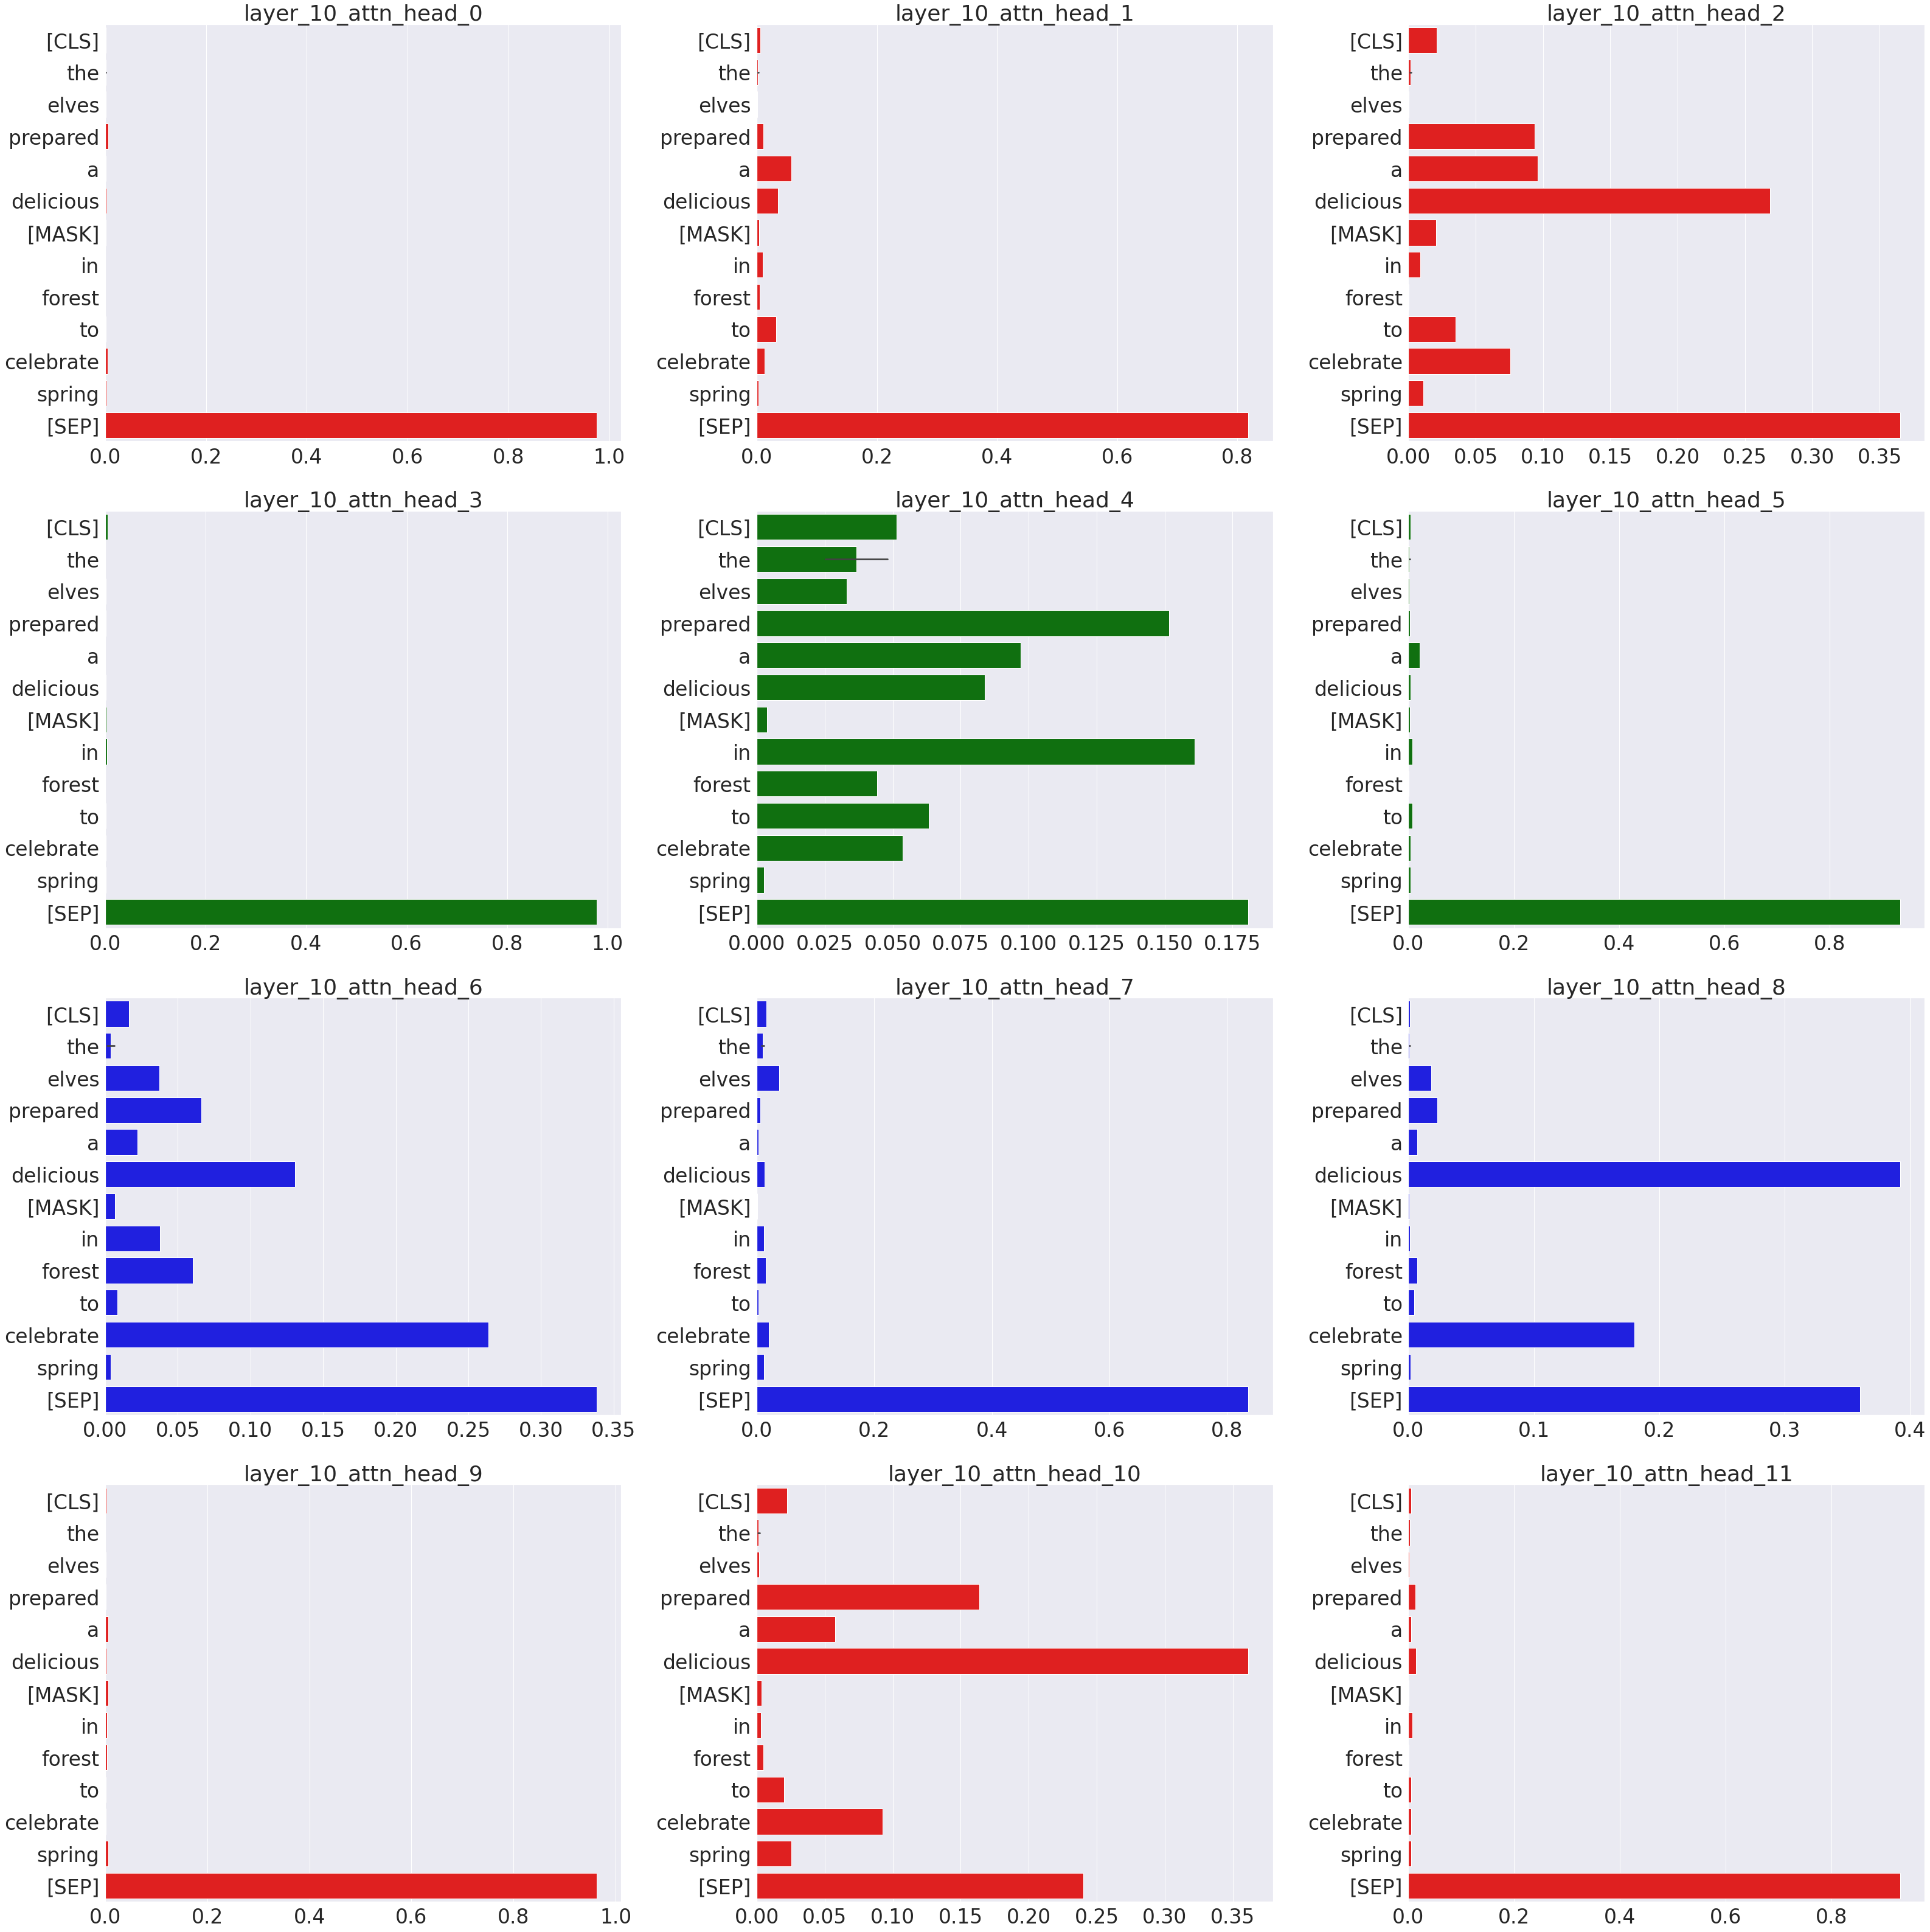

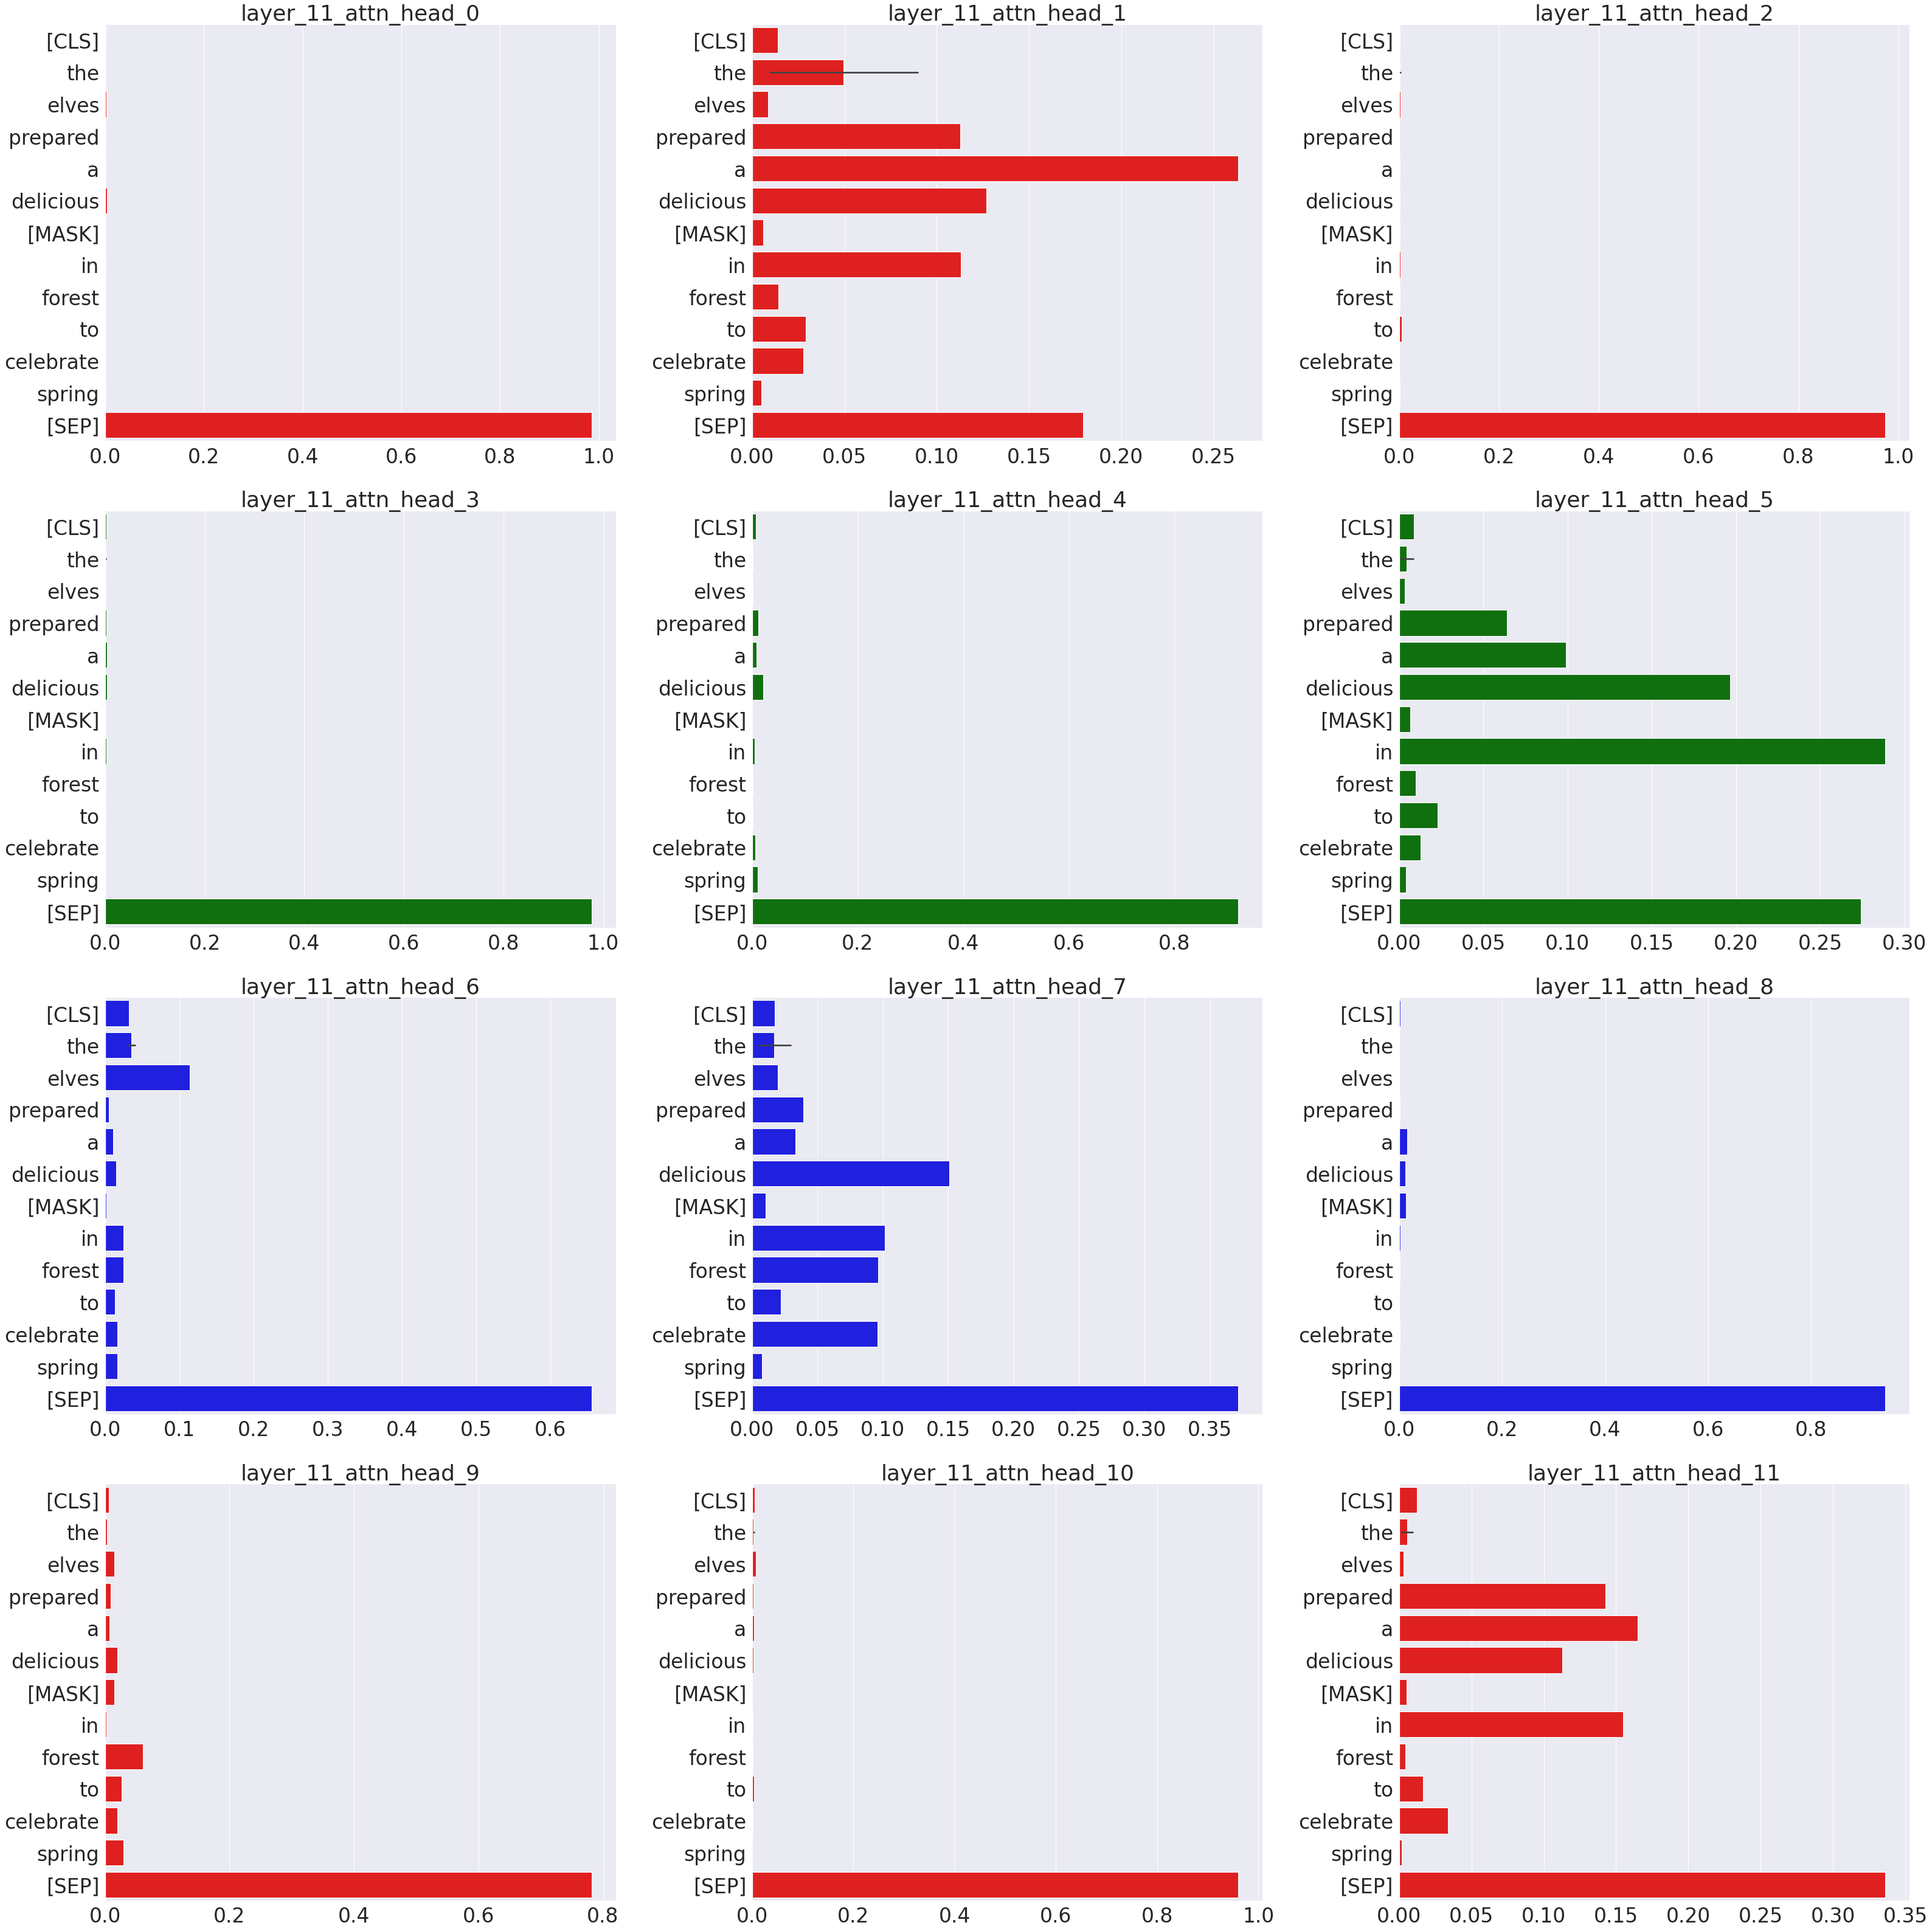

TypeError: ignored

In [72]:
x_labels = [tokenizer.decode(each_id) for each_id in tokenized_input["input_ids"][0]]
token_index = 6
for index, each_att_layer in enumerate(attentions):
  attn_heads = each_att_layer[0]
  layer_keys = ['layer_{}_attn_head_{}'.format(index,i) for i in range(0,12)]
  layer_wise_weights = attn_heads[:, token_index,:]
  layer_wise_weights = dict(zip(layer_keys, layer_wise_weights))
  h_args = {
      "layer_wise_weights":layer_wise_weights,
      "layer_keys":layer_keys, "row_num":4,"col_num":3,"method":plot_barplot,"method_kwargs":{"y":x_labels}
  }
  layer_wise_summary(**h_args)
  #break
attentions = torch.stack(attentions)
layer_keys = ['layer_{}_attn_head_11'.format(i) for i in range(0,12)]
layer_wise_weights = attentions[:,0,11,token_index,:]
layer_wise_weights = dict(zip(layer_keys, layer_wise_weights))
h_args = {
      "layer_wise_weights":layer_wise_weights,
      "layer_keys":layer_keys, "row_num":4,"col_num":3,"method":plot_barplot,"method_kwargs":{"y":x_labels}
  }
layer_wise_summary(**h_args)


In [56]:
t = torch.tensor([0.0606, 0.0493, 0.0358, 0.0452, 0.0619, 0.0538, 0.1848, 0.0842, 0.0552,
        0.0536, 0.1158, 0.0732, 0.0608, 0.0657])
x = ['A', 'B', 'C']
y = [1, 5, 3]

scores = t.flatten().numpy()
x_labels = [tokenizer.decode(each_id) for each_id in tokenized_input["input_ids"][0]]
sns.barplot(x=scores, y=x_labels, orient='h')
plt.show()

AttributeError: ignored

In [ ]:
t.flatten().numpy()

array([0.0606, 0.0493, 0.0358, 0.0452, 0.0619, 0.0538, 0.1848, 0.0842,
       0.0552, 0.0536, 0.1158, 0.0732, 0.0608, 0.0657], dtype=float32)